# 季節性検出 探索的分析ノートブック

## 目的
製造業の不定期生産ロットデータから、複数の季節性検出手法を比較検証し、最適な分析パイプラインを設計する。

## データ仕様
- 入力：CSV（columns: date, time, sensor_1, sensor_2, ..., sensor_60）
- 各センサー：1日あたり1〜50ロットの中央値を代表値として記録
- 欠損率：1%未満
- 期間：最大4年、長期休止（数週間〜数ヶ月）含む
- 外れ値：スパイクノイズ、設備設定変更による突然の変化

In [1]:
# ============================================================
# 環境設定とライブラリインポート
# ============================================================
import warnings
warnings.filterwarnings('ignore')

import gc
import time
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats, signal
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import ruptures as rpt

from tqdm.notebook import tqdm

# 再現性のためのシード固定
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 表示設定
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# 出力ディレクトリ
OUTPUT_DIR = Path('results/exploration')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('ライブラリのインポート完了')

ライブラリのインポート完了


---
# セクション1：データ読み込みと基礎統計
---

## 1.1 CSVロード、timestamp生成、基本情報表示

In [2]:
# ============================================================
# ??1: CSV????timestamp??
# ============================================================

# ?????????????????????????
DATA_PATH = Path('../data/sample_sensor_data.csv')
# ??????????????????????????????????
if not DATA_PATH.exists():
    alt = Path.cwd().parent / 'data' / 'sample_sensor_data.csv'
    if alt.exists():
        DATA_PATH = alt
    else:
        raise FileNotFoundError(f'???????????????: {DATA_PATH} / {alt}')
print(f'DATA_PATH: {DATA_PATH}')

# CSV???
df_raw = pd.read_csv(DATA_PATH)

# timestamp???date + time?????
if 'time' in df_raw.columns:
    df_raw['timestamp'] = pd.to_datetime(df_raw['date'] + ' ' + df_raw['time'])
else:
    df_raw['timestamp'] = pd.to_datetime(df_raw['date'])

# timestamp??????????
df_raw = df_raw.set_index('timestamp').sort_index()

# ???????
cols_to_drop = [col for col in ['date', 'time'] if col in df_raw.columns]
df_raw = df_raw.drop(columns=cols_to_drop)

# ????????
sensor_cols = [col for col in df_raw.columns if col.startswith('sensor_')]

print('=== ??????? ===')
print(f'?????: {df_raw.index.min()} ? {df_raw.index.max()}')
print(f'??????: {len(df_raw):,}')
print(f'?????: {len(sensor_cols)}')
print(f'?????: {sensor_cols[:5]}...' if len(sensor_cols) > 5 else f'?????: {sensor_cols}')
print(f'\n????:\n{df_raw.dtypes}')
print(f'\n??5?:\n{df_raw.head()}')


DATA_PATH: ../data/sample_sensor_data.csv
=== ??????? ===
?????: 2022-01-01 11:12:57 ? 2025-12-28 12:41:55
??????: 1,412
?????: 40
?????: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']...

????:
ROLot            str
sensor_1     float64
sensor_2     float64
sensor_3     float64
sensor_4     float64
sensor_5     float64
sensor_6     float64
sensor_7     float64
sensor_8     float64
sensor_9     float64
sensor_10    float64
sensor_11    float64
sensor_12    float64
sensor_13    float64
sensor_14    float64
sensor_15    float64
sensor_16    float64
sensor_17    float64
sensor_18    float64
sensor_19    float64
sensor_20    float64
sensor_21    float64
sensor_22    float64
sensor_23    float64
sensor_24    float64
sensor_25    float64
sensor_26    float64
sensor_27    float64
sensor_28    float64
sensor_29    float64
sensor_30    float64
sensor_31    float64
sensor_32    float64
sensor_33    float64
sensor_34    float64
sensor_35    float64
sensor_36    float64
sensor_37    f

## 1.2 欠損パターンの可視化（ヒートマップ）

=== 欠損値サマリー ===
欠損があるセンサー数: 40
最大欠損率: 0.85%


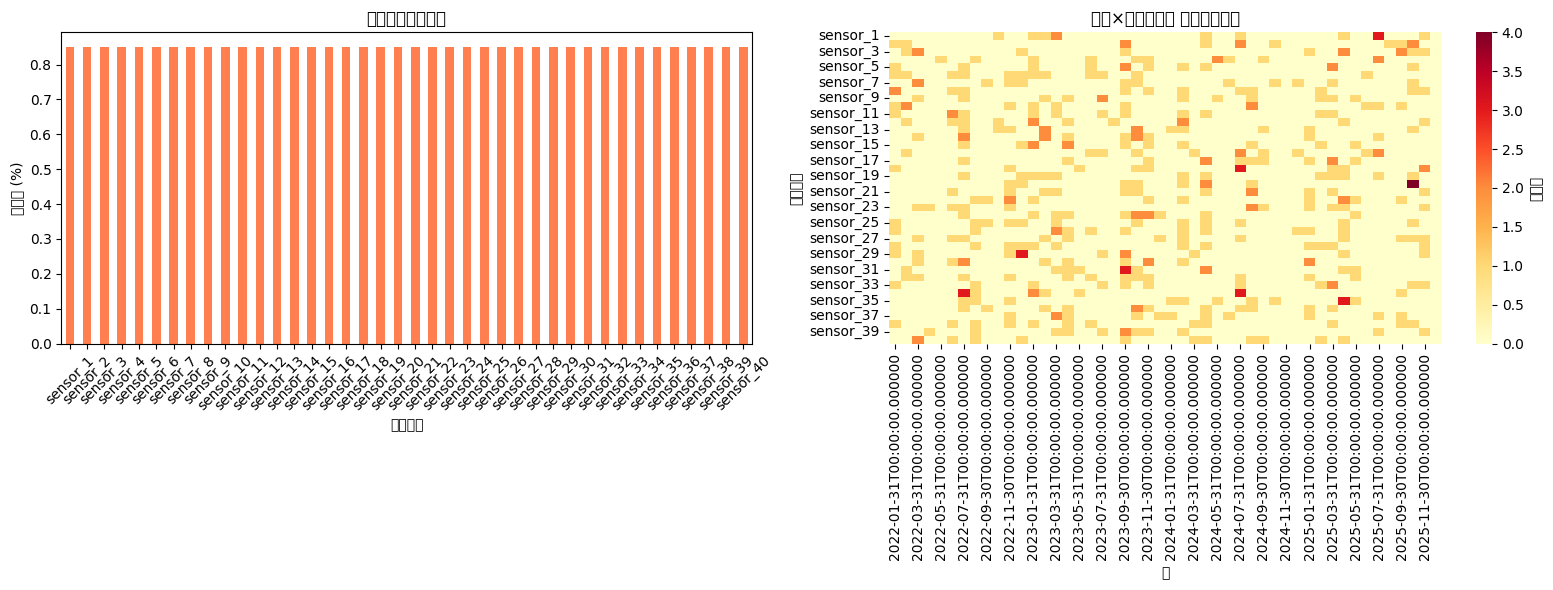

In [3]:
# ============================================================
# セル2: 欠損パターンの可視化
# ============================================================

# 欠損値の概要
missing_summary = df_raw[sensor_cols].isnull().sum()
missing_pct = (missing_summary / len(df_raw) * 100).round(2)

print('=== 欠損値サマリー ===')
print(f'欠損があるセンサー数: {(missing_summary > 0).sum()}')
print(f'最大欠損率: {missing_pct.max():.2f}%')

# 月別欠損パターンのヒートマップ
df_monthly_missing = df_raw[sensor_cols].resample('ME').apply(lambda x: x.isnull().sum())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左: センサー別欠損率
ax1 = axes[0]
missing_pct.plot(kind='bar', ax=ax1, color='coral')
ax1.set_title('センサー別欠損率')
ax1.set_xlabel('センサー')
ax1.set_ylabel('欠損率 (%)')
ax1.tick_params(axis='x', rotation=45)

# 右: 月別×センサー別欠損ヒートマップ
ax2 = axes[1]
if len(df_monthly_missing) > 0 and df_monthly_missing.values.sum() > 0:
    sns.heatmap(df_monthly_missing.T, cmap='YlOrRd', ax=ax2, cbar_kws={'label': '欠損数'})
    ax2.set_title('月別×センサー別 欠損パターン')
    ax2.set_xlabel('月')
    ax2.set_ylabel('センサー')
else:
    ax2.text(0.5, 0.5, '欠損なし', ha='center', va='center', fontsize=14)
    ax2.set_title('月別×センサー別 欠損パターン')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'missing_pattern.png', dpi=150, bbox_inches='tight')
plt.show()

## 1.3 各センサーの記述統計（平均、標準偏差、歪度、尖度）

In [4]:
# ============================================================
# セル3: 記述統計
# ============================================================

def calc_descriptive_stats(series):
    """センサー単位の記述統計を計算"""
    return pd.Series({
        'count': series.count(),
        'mean': series.mean(),
        'std': series.std(),
        'min': series.min(),
        'q25': series.quantile(0.25),
        'median': series.median(),
        'q75': series.quantile(0.75),
        'max': series.max(),
        'skewness': stats.skew(series.dropna()),
        'kurtosis': stats.kurtosis(series.dropna()),
        'cv': series.std() / series.mean() if series.mean() != 0 else np.nan  # 変動係数
    })

# 全センサーの記述統計を計算
desc_stats = df_raw[sensor_cols].apply(calc_descriptive_stats).T
desc_stats = desc_stats.round(4)

print('=== 記述統計 ===')
display(desc_stats)

# CSV出力
desc_stats.to_csv(OUTPUT_DIR / 'descriptive_statistics.csv')
print(f'\n保存: {OUTPUT_DIR / "descriptive_statistics.csv"}')

=== 記述統計 ===


count      mean      std       min       q25    median       q75  \
sensor_1   1400.0   99.5126  10.8634   70.6934   91.7305   99.6007  107.7550   
sensor_2   1400.0  115.7237  16.9701   66.7994  103.4418  115.9099  127.8466   
sensor_3   1400.0  115.7075  10.6299   91.0976  107.9174  115.7706  123.4614   
sensor_4   1400.0  139.0195  14.3031   94.3821  129.7144  138.9748  148.9157   
sensor_5   1400.0   95.0841  12.2435   66.2964   85.0734   95.2822  105.0180   
sensor_6   1400.0  144.1831  22.2592   87.5882  129.2799  144.3949  159.3820   
sensor_7   1400.0  114.8290  12.9955   80.8390  105.6430  114.3479  123.6429   
sensor_8   1400.0  116.9028  14.6384   79.4805  106.2918  116.5205  128.1326   
sensor_9   1400.0   96.5315  11.8449   64.2655   88.2105   96.5608  104.3751   
sensor_10  1400.0  105.2132  13.1428   69.5695   96.0851  105.0735  114.0470   
sensor_11  1400.0  102.3042  17.1134   55.2082   90.4457  103.7278  115.3404   
sensor_12  1400.0  135.0615   8.3564  109.9424  129.5942  135.0048  140.3225   
sensor_13  1400.0  123.5806  15.1154   91.8356  110.4521  123.1409  136.5016   
sensor_14  1400.0  113.9847  15.9378   65.2160  102.8845  114.1324  125.0856   
sensor_15  1400.0  151.7646  15.1825  120.4877  139.5808  150.9227  163.7202   
sensor_16  1400.0  114.5216  12.7111   82.3226  105.1764  114.3661  123.3808   
sensor_17  1400.0  147.1594  19.1368  105.8403  133.2426  145.7387  159.3793   
sensor_18  1400.0  145.7862  22.2380   89.3470  130.1907  145.8262  161.4023   
sensor_19  1400.0  130.0805  20.7323   76.3638  115.0342  130.4851  143.7104   
sensor_20  1400.0   70.8385  14.0320   39.0928   59.4031   71.2544   81.3108   
sensor_21  1400.0   66.9937  17.0238   29.8334   55.0380   66.5596   78.5361   
sensor_22  1400.0   92.4030  20.8199   36.7944   78.2384   91.6263  106.5981   
sensor_23  1400.0  111.3031  14.2270   75.3307  100.5053  111.7295  121.4762   
sensor_24  1400.0   56.9074  16.6392   11.5048   45.3062   56.7839   69.0382   
sensor_25  1400.0  123.5839  11.8286   92.5972  115.1557  123.8202  132.1358   
sensor_26  1400.0  114.0380  14.7531   83.9650  102.9411  113.8038  123.6194   
sensor_27  1400.0   99.2440  12.5270   62.2920   90.6768   99.1982  107.4960   
sensor_28  1400.0   89.8651  19.0740   42.2108   76.0499   89.7075  103.8962   
sensor_29  1400.0   76.1666  15.9649   35.5717   64.3572   76.6685   87.7992   
sensor_30  1400.0   74.2480   8.4590   53.3484   68.4578   74.3728   80.0391   
sensor_31  1400.0  111.8320  13.3327   79.2005  102.4033  111.3559  121.6876   
sensor_32  1400.0   76.5325  16.8326   39.5451   64.3058   75.7011   89.4328   
sensor_33  1400.0  119.7464  12.7281   88.9172  110.5671  119.7771  128.9847   
sensor_34  1400.0  104.7617  16.0613   64.9717   92.0119  105.4508  117.0340   
sensor_35  1400.0  118.2941  18.2096   74.3029  104.1424  117.9016  131.2753   
sensor_36  1400.0  141.2072  16.4092  101.1699  128.1888  142.0782  153.5851   
sensor_37  1400.0  102.7206  10.3201   78.9094   95.3911  102.4314  110.0581   
sensor_38  1400.0   72.3048  13.5338   36.3485   62.9513   71.9126   82.1316   
sensor_39  1400.0  108.0561  16.3483   62.3857   97.1944  108.6251  119.6135   
sensor_40  1400.0   74.9562  13.4808   39.3899   65.7309   74.9434   84.6615   

                max  skewness  kurtosis      cv  
sensor_1   141.7951   -0.0761   -0.5212  0.1092  
sensor_2   181.8338    0.0366   -0.1728  0.1466  
sensor_3   180.8118    0.3587    1.5110  0.0919  
sensor_4   195.8756    0.0074    0.1142  0.1029  
sensor_5   148.3663    0.1175   -0.3847  0.1288  
sensor_6   261.0208    0.1205    0.3051  0.1544  
sensor_7   181.7093    0.2992    0.7756  0.1132  
sensor_8   152.3258   -0.0025   -0.5703  0.1252  
sensor_9   165.2787    0.2351    0.7278  0.1227  
sensor_10  163.0407    0.0290   -0.0653  0.1249  
sensor_11  167.8864   -0.2391   -0.3707  0.1673  
sensor_12  197.2107    0.7053    4.3959  0.0619  
sensor_13  179.7135    0.1342   -0.9696  0.1223  
sensor_14  170.0073   -0.0406  


保存: results/exploration/descriptive_statistics.csv


## 1.4 時系列プロット（全センサー、サブプロット形式）

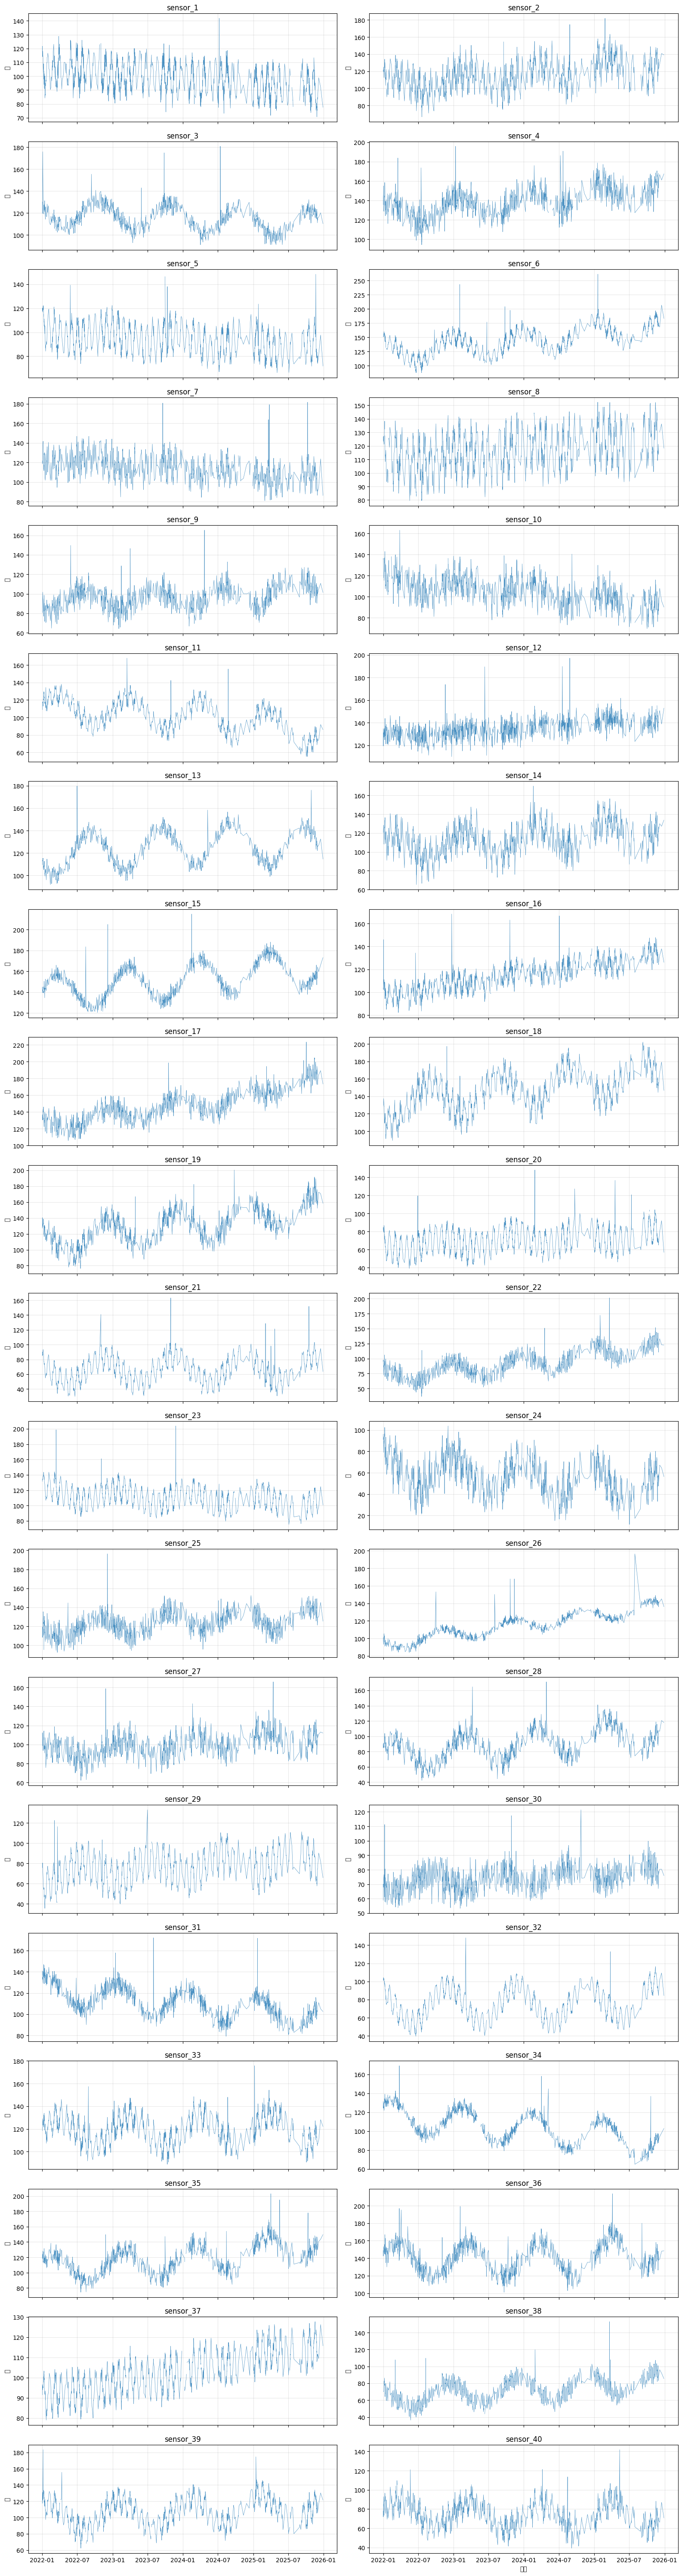

In [5]:
# ============================================================
# セル4: 時系列プロット
# ============================================================

n_sensors = len(sensor_cols)
n_cols = 2
n_rows = (n_sensors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows), sharex=True)
axes = axes.flatten() if n_sensors > 1 else [axes]

for i, col in enumerate(sensor_cols):
    ax = axes[i]
    ax.plot(df_raw.index, df_raw[col], linewidth=0.5, alpha=0.8)
    ax.set_title(col)
    ax.set_ylabel('値')
    ax.grid(True, alpha=0.3)

# 余ったサブプロットを非表示
for i in range(n_sensors, len(axes)):
    axes[i].set_visible(False)

plt.xlabel('日付')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'time_series_all_sensors.png', dpi=150, bbox_inches='tight')
plt.show()

---
# セクション2：前処理の比較検証
---

## 2.1 不等間隔データの扱い

### 理論背景
製造データは生産スケジュールに依存するため、不等間隔になりやすい。
季節性検出の多くの手法（FFT、STLなど）は等間隔データを前提とするため、
リサンプリングと補間が必要になる。

- **リサンプリング手法**: mean（平均）、median（中央値）、ffill（前方埋め）
- **補間手法**: linear（線形）、spline（スプライン）、None（補間なし=NaN維持）

In [6]:
# ============================================================
# セル5: リサンプリング・補間手法の比較
# ============================================================

def resample_and_interpolate(df, sensor_col, resample_method='mean', interp_method='linear'):
    """
    日次リサンプリングと補間を実行
    
    Parameters:
    -----------
    df : DataFrame
        入力データ（timestampがインデックス）
    sensor_col : str
        対象センサー列名
    resample_method : str
        'mean', 'median', 'ffill'
    interp_method : str or None
        'linear', 'spline', None
    """
    series = df[sensor_col].copy()
    
    # 日次リサンプリング
    if resample_method == 'mean':
        resampled = series.resample('D').mean()
    elif resample_method == 'median':
        resampled = series.resample('D').median()
    elif resample_method == 'ffill':
        resampled = series.resample('D').ffill()
    else:
        raise ValueError(f'Unknown resample_method: {resample_method}')
    
    # 補間
    if interp_method == 'linear':
        resampled = resampled.interpolate(method='linear')
    elif interp_method == 'spline':
        resampled = resampled.interpolate(method='spline', order=3)
    elif interp_method is None:
        pass  # NaN維持
    else:
        raise ValueError(f'Unknown interp_method: {interp_method}')
    
    return resampled

# 代表センサー3本を選択（先頭3つ）
representative_sensors = sensor_cols[:3]

# 各組み合わせで処理
resample_methods = ['mean', 'median', 'ffill']
interp_methods = ['linear', 'spline', None]

# 結果格納
resampled_results = {}

for sensor in representative_sensors:
    resampled_results[sensor] = {}
    for rm in resample_methods:
        for im in interp_methods:
            key = f'{rm}_{im}'
            resampled_results[sensor][key] = resample_and_interpolate(
                df_raw, sensor, resample_method=rm, interp_method=im
            )

print(f'処理完了: {len(representative_sensors)}センサー × {len(resample_methods)}リサンプリング × {len(interp_methods)}補間 = {len(representative_sensors) * len(resample_methods) * len(interp_methods)}パターン')

処理完了: 3センサー × 3リサンプリング × 3補間 = 27パターン


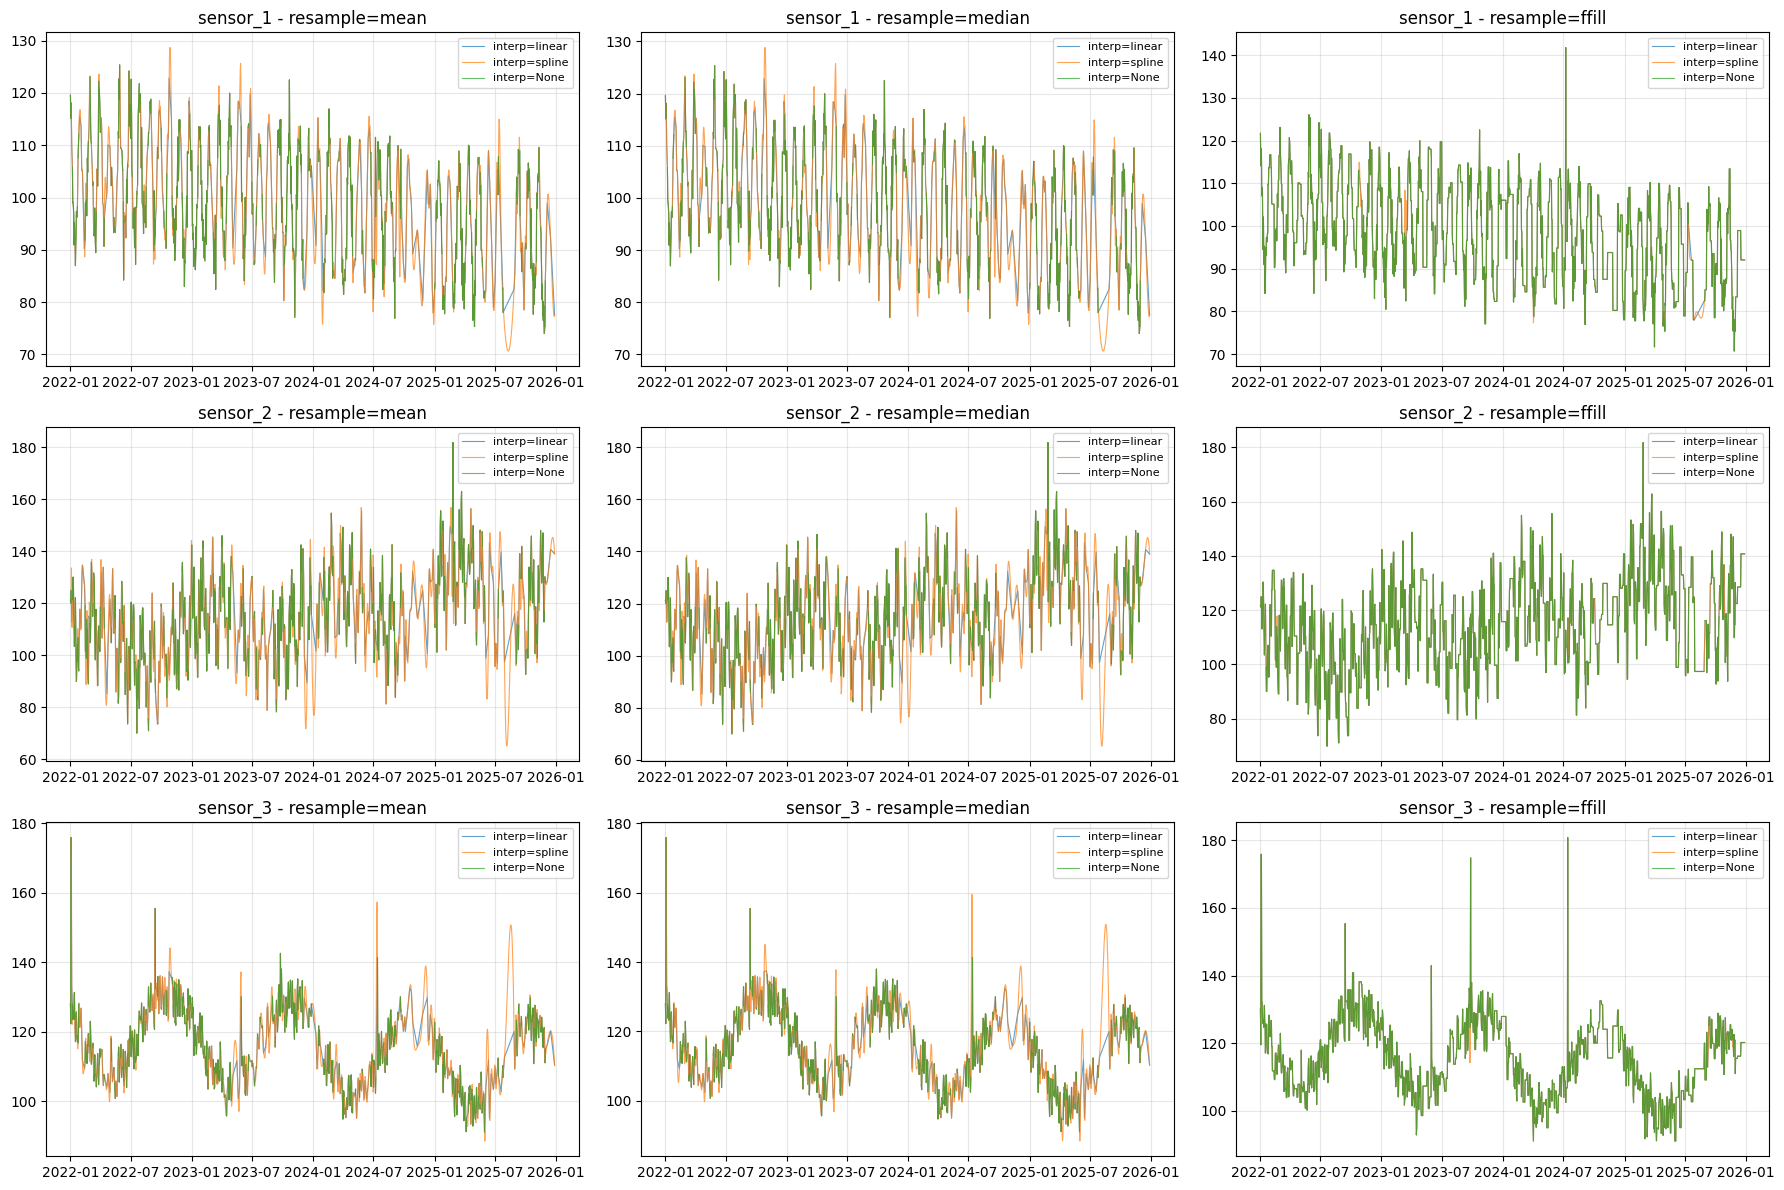

In [7]:
# ============================================================
# セル5b: リサンプリング・補間結果の可視化
# ============================================================

fig, axes = plt.subplots(len(representative_sensors), 3, figsize=(18, 4 * len(representative_sensors)))

for i, sensor in enumerate(representative_sensors):
    for j, rm in enumerate(resample_methods):
        ax = axes[i, j] if len(representative_sensors) > 1 else axes[j]
        
        for im in interp_methods:
            key = f'{rm}_{im}'
            label = f'interp={im}' if im else 'interp=None'
            data = resampled_results[sensor][key]
            ax.plot(data.index, data.values, label=label, alpha=0.7, linewidth=0.8)
        
        ax.set_title(f'{sensor} - resample={rm}')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'resampling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 2.2 外れ値検出

### 理論背景
- **IQR法**: 四分位範囲（Q3-Q1）の1.5倍を超える値を外れ値とする古典的手法
- **Z-score**: 平均から標準偏差の何倍離れているかで判定（通常|z|>3）
- **Isolation Forest**: 異常値は「孤立しやすい」という性質を利用した機械学習手法

In [8]:
# ============================================================
# セル6: 外れ値検出手法の比較
# ============================================================

def detect_outliers_iqr(series, k=1.5):
    """IQR法による外れ値検出"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series, threshold=3):
    """Z-score法による外れ値検出"""
    z = np.abs(stats.zscore(series.dropna()))
    outlier_idx = series.dropna().index[z > threshold]
    return series.index.isin(outlier_idx)

def detect_outliers_isolation_forest(series, contamination=0.05, random_state=RANDOM_SEED):
    """Isolation Forestによる外れ値検出"""
    data = series.dropna().values.reshape(-1, 1)
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(data)
    outlier_idx = series.dropna().index[preds == -1]
    return series.index.isin(outlier_idx)

# 代表センサーで各手法を適用（日次リサンプリング後のデータを使用）
outlier_results = {}

for sensor in tqdm(representative_sensors, desc='外れ値検出'):
    # mean + linear補間のデータを使用
    data = resampled_results[sensor]['mean_linear'].dropna()
    
    outlier_results[sensor] = {
        'data': data,
        'iqr': detect_outliers_iqr(data),
        'zscore': detect_outliers_zscore(data),
        'iforest': detect_outliers_isolation_forest(data)
    }

# 外れ値検出数の比較
outlier_summary = pd.DataFrame({
    sensor: {
        'IQR': outlier_results[sensor]['iqr'].sum(),
        'Z-score': outlier_results[sensor]['zscore'].sum(),
        'IsolationForest': outlier_results[sensor]['iforest'].sum(),
        'Total Points': len(outlier_results[sensor]['data'])
    }
    for sensor in representative_sensors
}).T

print('=== 外れ値検出数の比較 ===')
display(outlier_summary)

外れ値検出:   0%|          | 0/3 [00:00<?, ?it/s]

=== 外れ値検出数の比較 ===


IQR  Z-score  IsolationForest  Total Points
sensor_1    0        0               73          1458
sensor_2    2        2               72          1458
sensor_3    3        3               73          1458

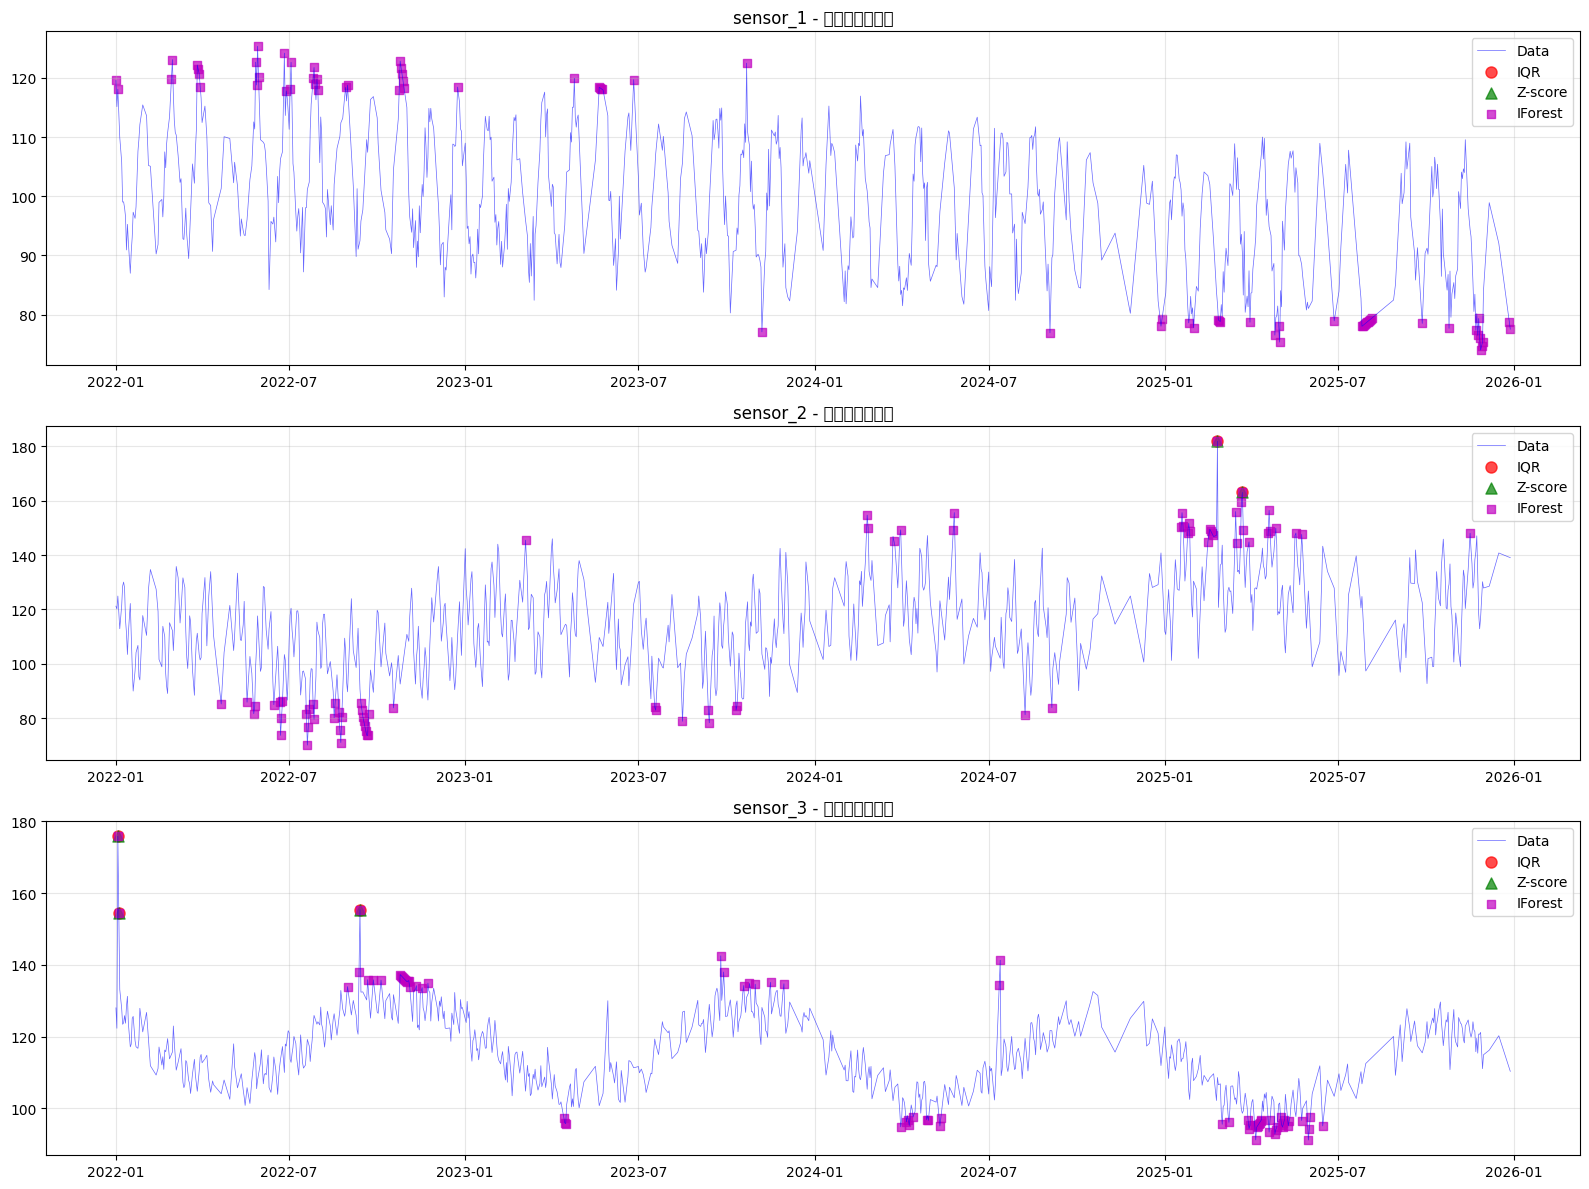

In [9]:
# ============================================================
# セル6b: 外れ値の時系列プロット
# ============================================================

fig, axes = plt.subplots(len(representative_sensors), 1, figsize=(16, 4 * len(representative_sensors)))
axes = [axes] if len(representative_sensors) == 1 else axes

for i, sensor in enumerate(representative_sensors):
    ax = axes[i]
    data = outlier_results[sensor]['data']
    
    # ベースの時系列
    ax.plot(data.index, data.values, 'b-', linewidth=0.5, alpha=0.6, label='Data')
    
    # 各手法の外れ値をマーカーで表示
    methods = [('iqr', 'IQR', 'ro', 8), ('zscore', 'Z-score', 'g^', 8), ('iforest', 'IForest', 'ms', 6)]
    
    for method_key, method_name, marker, size in methods:
        mask = outlier_results[sensor][method_key]
        outlier_data = data[mask]
        ax.scatter(outlier_data.index, outlier_data.values, 
                   marker=marker[1], c=marker[0], s=size**2, label=method_name, alpha=0.7)
    
    ax.set_title(f'{sensor} - 外れ値検出結果')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'outlier_detection_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 2.3 Changepoint Detection（構造変化点検出）

### 理論背景
製造プロセスでは設備変更や工程変更により、時系列の統計的性質が突然変化することがある。
この変化点を検出し、セグメントごとに季節性を分析することで精度向上が期待できる。

- **PELT法**: Pruned Exact Linear Time - 最適なコスト関数を持つ変化点を高速検出
- **Window法**: スライディングウィンドウで局所的な変化を検出

In [10]:
# ============================================================
# セル7: Changepoint Detection
# ============================================================

def detect_changepoints(series, method='pelt', model='rbf', min_size=30, penalty=10):
    """
    rupturesによる変化点検出
    
    Parameters:
    -----------
    series : pd.Series
        入力時系列
    method : str
        'pelt' or 'window'
    model : str
        コストモデル（'rbf', 'l1', 'l2'）
    min_size : int
        最小セグメント長
    penalty : float
        ペナルティパラメータ（変化点数を制御）
    """
    data = series.dropna().values
    
    if method == 'pelt':
        algo = rpt.Pelt(model=model, min_size=min_size).fit(data)
        result = algo.predict(pen=penalty)
    elif method == 'window':
        algo = rpt.Window(model=model, min_size=min_size, width=50).fit(data)
        result = algo.predict(pen=penalty)
    else:
        raise ValueError(f'Unknown method: {method}')
    
    # インデックスに変換
    change_indices = [series.dropna().index[i-1] for i in result[:-1]]
    return change_indices

# 変化点検出の実行
changepoint_results = {}

for sensor in tqdm(representative_sensors, desc='変化点検出'):
    data = resampled_results[sensor]['mean_linear'].dropna()
    
    changepoint_results[sensor] = {
        'data': data,
        'pelt': detect_changepoints(data, method='pelt', penalty=10),
        'window': detect_changepoints(data, method='window', penalty=10)
    }

# 検出された変化点数
print('=== 検出された変化点数 ===')
for sensor in representative_sensors:
    print(f'{sensor}: PELT={len(changepoint_results[sensor]["pelt"])}, Window={len(changepoint_results[sensor]["window"])}')

変化点検出:   0%|          | 0/3 [00:00<?, ?it/s]

=== 検出された変化点数 ===
sensor_1: PELT=3, Window=4
sensor_2: PELT=5, Window=0
sensor_3: PELT=14, Window=2


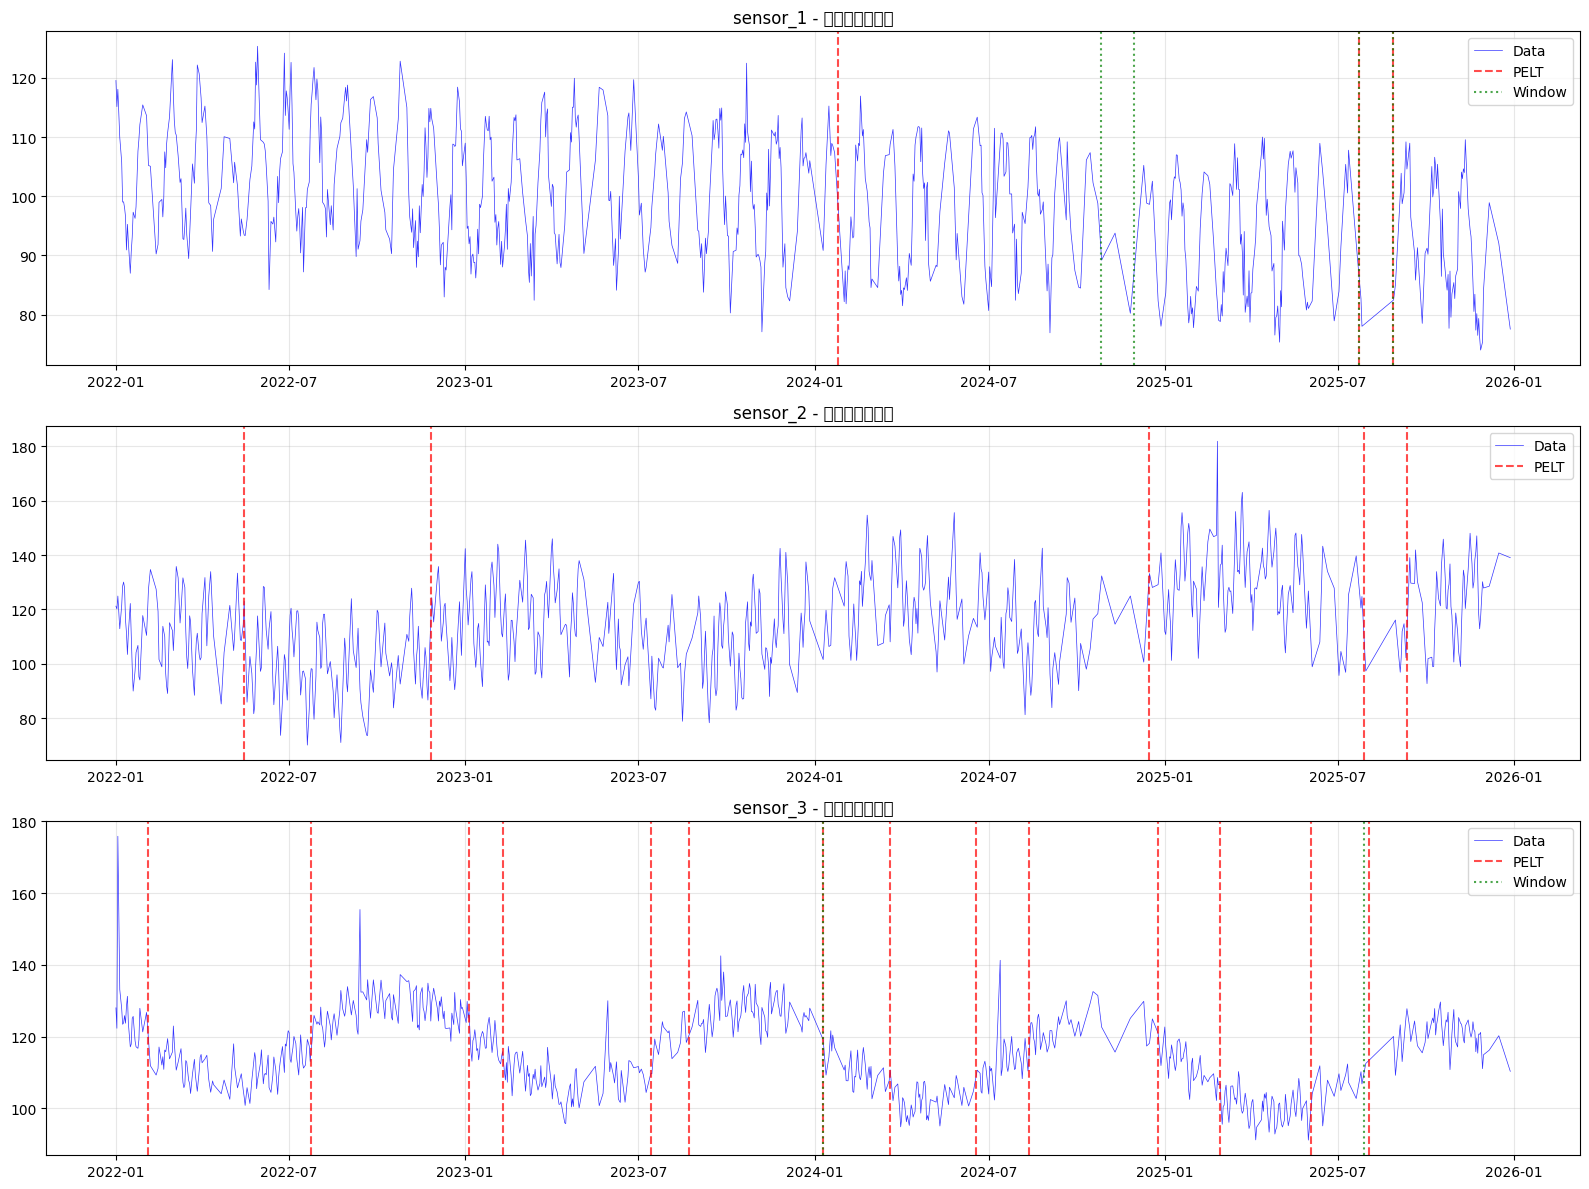

In [11]:
# ============================================================
# セル7b: 変化点の可視化
# ============================================================

fig, axes = plt.subplots(len(representative_sensors), 1, figsize=(16, 4 * len(representative_sensors)))
axes = [axes] if len(representative_sensors) == 1 else axes

for i, sensor in enumerate(representative_sensors):
    ax = axes[i]
    data = changepoint_results[sensor]['data']
    
    # 時系列プロット
    ax.plot(data.index, data.values, 'b-', linewidth=0.5, alpha=0.8, label='Data')
    
    # PELT変化点（赤縦線）
    for cp in changepoint_results[sensor]['pelt']:
        ax.axvline(x=cp, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='PELT' if cp == changepoint_results[sensor]['pelt'][0] else '')
    
    # Window変化点（緑縦線）
    for cp in changepoint_results[sensor]['window']:
        ax.axvline(x=cp, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label='Window' if cp == changepoint_results[sensor]['window'][0] else '')
    
    ax.set_title(f'{sensor} - 変化点検出結果')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'changepoint_detection.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# ============================================================
# セル7c: 変化点前後のセグメント統計比較
# ============================================================

def segment_statistics(series, changepoints):
    """変化点で分割したセグメントの統計を計算"""
    segments = []
    boundaries = [series.index[0]] + list(changepoints) + [series.index[-1]]
    
    for j in range(len(boundaries) - 1):
        start, end = boundaries[j], boundaries[j+1]
        segment = series[start:end]
        segments.append({
            'segment': j + 1,
            'start': start,
            'end': end,
            'n_points': len(segment),
            'mean': segment.mean(),
            'std': segment.std(),
            'min': segment.min(),
            'max': segment.max()
        })
    return pd.DataFrame(segments)

# 代表センサーのセグメント統計（PELT変化点を使用）
print('=== セグメント統計（PELT変化点） ===')
for sensor in representative_sensors:
    data = changepoint_results[sensor]['data']
    cps = changepoint_results[sensor]['pelt']
    seg_stats = segment_statistics(data, cps)
    print(f'\n{sensor}:')
    display(seg_stats)

=== セグメント統計（PELT変化点） ===

sensor_1:


segment      start        end  n_points        mean       std        min  \
0        1 2022-01-01 2024-01-25       755  102.548744  9.471126  77.092322   
1        2 2024-01-25 2025-07-23       546   95.179741  9.465349  75.345577   
2        3 2025-07-23 2025-08-27        36   80.544023  1.803544  78.026674   
3        4 2025-08-27 2025-12-28       124   91.626735  8.873160  74.007112   

          max  
0  125.360368  
1  116.945279  
2   86.413999  
3  109.571125


sensor_2:


segment      start        end  n_points        mean        std        min  \
0        1 2022-01-01 2022-05-15       135  112.988658  12.268975  85.207258   
1        2 2022-05-15 2022-11-26       196   99.705627  12.380569  70.109182   
2        3 2022-11-26 2024-12-15       751  114.517513  13.455899  78.311187   
3        4 2024-12-15 2025-07-28       226  128.786505  14.188885  95.704350   
4        5 2025-07-28 2025-09-11        46  106.910840   5.565810  96.900992   
5        6 2025-09-11 2025-12-28       109  126.131006  13.136362  92.710461   

          max  
0  135.806792  
1  128.436760  
2  155.598781  
3  181.833777  
4  116.101381  
5  148.015014


sensor_3:


segment      start        end  n_points        mean        std  \
0         1 2022-01-01 2022-02-04        35  125.944383  10.960419   
1         2 2022-02-04 2022-07-24       171  111.009489   4.772033   
2         3 2022-07-24 2023-01-05       166  128.128729   5.100989   
3         4 2023-01-05 2023-02-09        36  118.527063   3.757764   
4         5 2023-02-09 2023-07-14       156  108.204128   4.977623   
5         6 2023-07-14 2023-08-23        41  118.623798   4.208542   
6         7 2023-08-23 2024-01-10       141  126.435318   4.351227   
7         8 2024-01-10 2024-03-20        71  111.080207   4.198001   
8         9 2024-03-20 2024-06-18        91  102.632953   3.559559   
9        10 2024-06-18 2024-08-12        56  113.293659   6.656611   
10       11 2024-08-12 2024-12-25       136  122.858516   4.340027   
11       12 2024-12-25 2025-02-28        66  111.800831   4.662393   
12       13 2025-02-28 2025-06-03        96   99.978992   4.042940   
13       14 2025-06-03 2025-08-02        61  106.589718   3.605475   
14       15 2025-08-02 2025-12-28       149  119.103909   4.132075   

           min         max  
0   116.719114  175.834673  
1   100.790534  122.942937  
2   116.454788  155.406029  
3   112.385483  126.942226  
4    95.717716  129.988345  
5   109.582627  127.068446  
6   115.549640  142.496724  
7   102.627065  121.617807  
8    94.822109  110.729696  
9   102.302231  141.263123  
10  113.666373  132.547962  
11  102.165037  122.673706  
12   91.135774  110.250096  
13   95.084972  113.270947  
14  109.185536  129.648655

---
# セクション3：季節性検出手法の実装と比較
---

## 3.1 STL分解（Seasonal-Trend decomposition using Loess）

### 理論背景
STLは時系列を**Trend（トレンド）**、**Seasonal（季節成分）**、**Residual（残差）**の3成分に分解する手法。
局所重み付け回帰（LOESS）を使用し、外れ値にロバスト。

**季節成分の強度スコア**: $F_{season} = \frac{Var(Seasonal)}{Var(Residual)}$

F_seasonが大きいほど季節性が強い。

In [13]:
# ============================================================
# セル8: STL分解
# ============================================================

def perform_stl_decomposition(series, period):
    """
    STL分解を実行し、季節性強度スコアを計算
    
    Parameters:
    -----------
    series : pd.Series
        入力時系列（等間隔・欠損なし）
    period : int
        季節周期（日数）
    
    Returns:
    --------
    dict: 分解結果とスコア
    """
    # データ長チェック
    if len(series) < 2 * period:
        return None
    
    try:
        stl = STL(series, period=period, robust=True)
        result = stl.fit()
        
        # 季節性強度スコア
        var_seasonal = np.var(result.seasonal)
        var_residual = np.var(result.resid)
        f_season = var_seasonal / var_residual if var_residual > 0 else 0
        
        # 正規化スコア（0-1にクリップ）
        score_normalized = min(f_season / (f_season + 1), 1.0)
        
        return {
            'trend': result.trend,
            'seasonal': result.seasonal,
            'residual': result.resid,
            'f_season': f_season,
            'score': score_normalized
        }
    except Exception as e:
        print(f'STL error (period={period}): {e}')
        return None

# 周期候補
periods = [7, 30, 365]

# STL分解結果の格納
stl_results = {}

for sensor in tqdm(representative_sensors, desc='STL分解'):
    data = resampled_results[sensor]['mean_linear'].dropna()
    stl_results[sensor] = {}
    
    for period in periods:
        result = perform_stl_decomposition(data, period)
        if result:
            stl_results[sensor][period] = result

# スコアサマリー
stl_scores = pd.DataFrame({
    sensor: {
        f'period_{p}': stl_results[sensor].get(p, {}).get('score', np.nan)
        for p in periods
    }
    for sensor in representative_sensors
}).T

print('=== STL季節性スコア（F_season正規化） ===')
display(stl_scores.round(4))

STL分解:   0%|          | 0/3 [00:00<?, ?it/s]

=== STL季節性スコア（F_season正規化） ===


period_7  period_30  period_365
sensor_1    0.1785     0.8375      0.7035
sensor_2    0.6124     0.6454      0.7210
sensor_3    0.3693     0.2656      0.8899

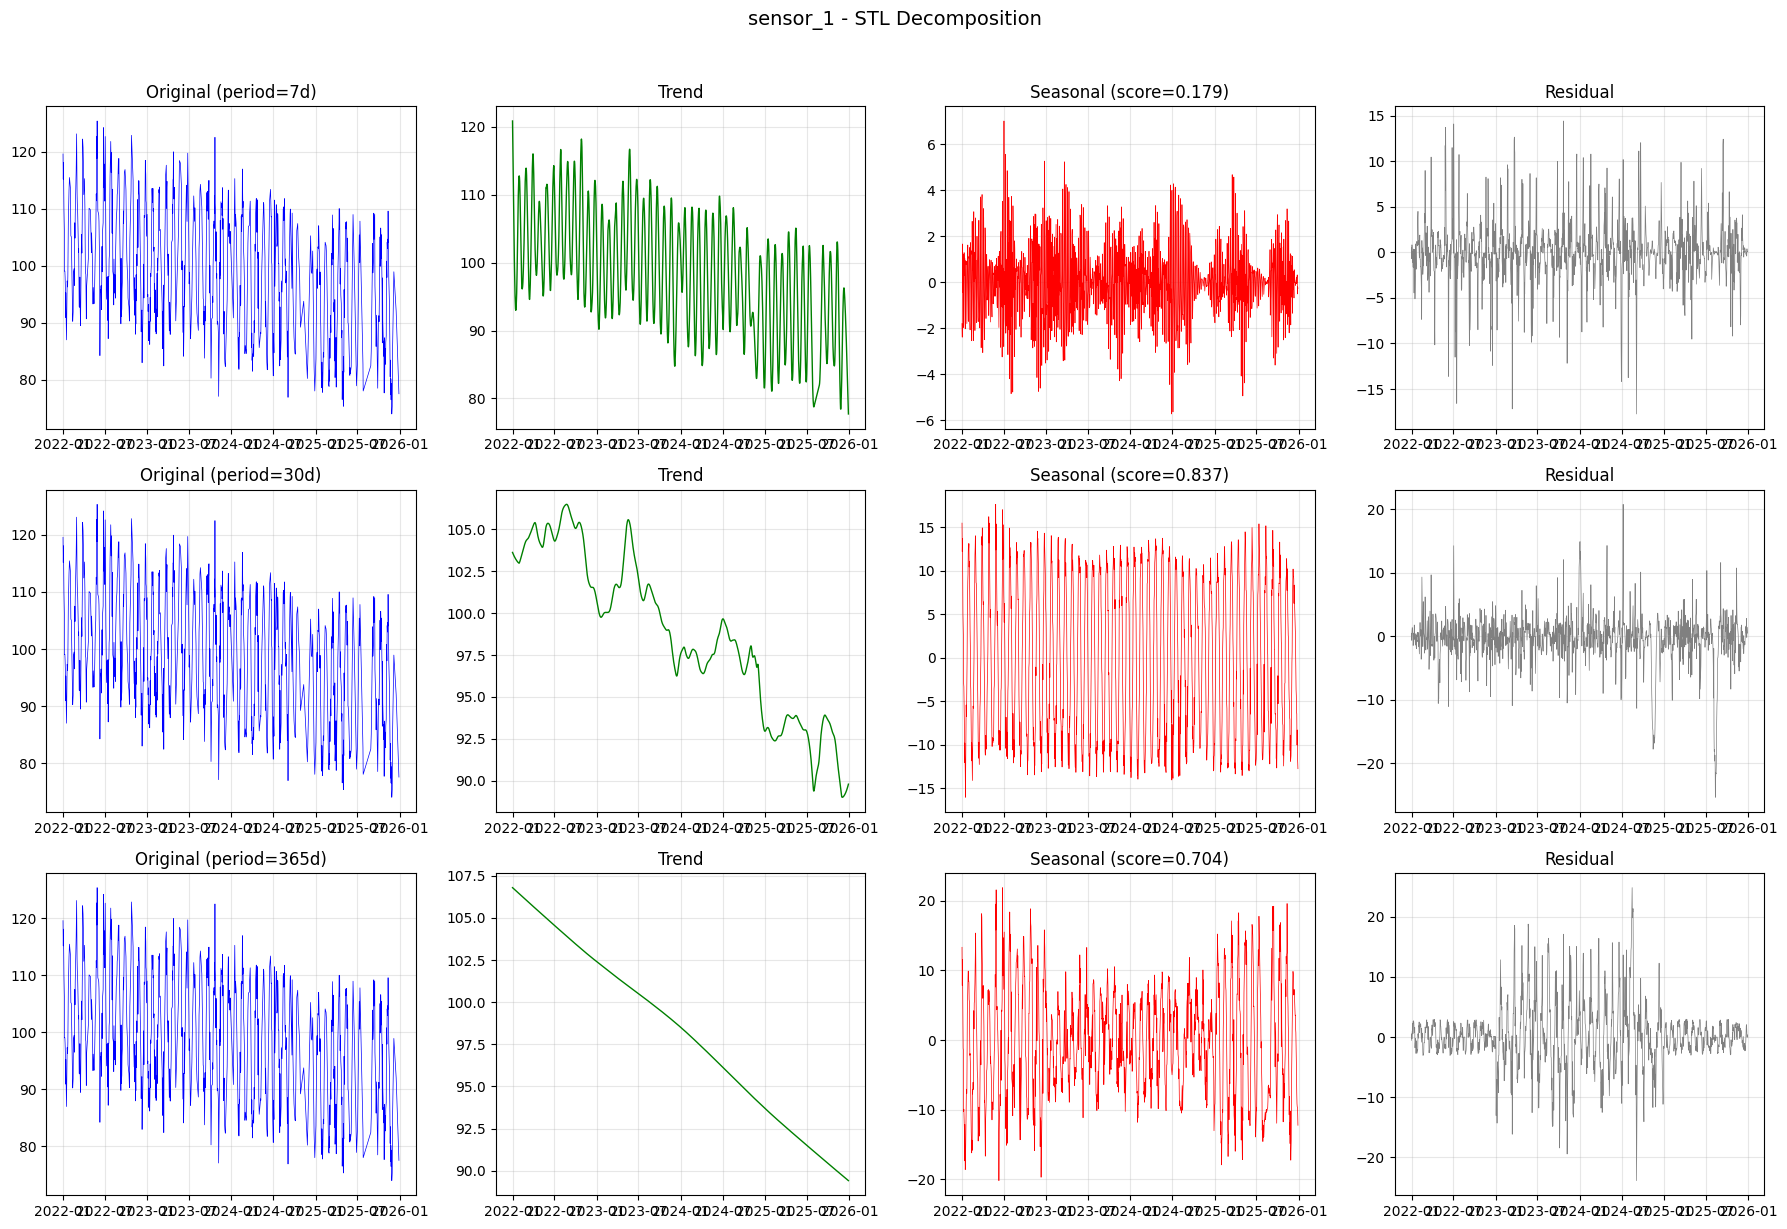

In [14]:
# ============================================================
# セル8b: STL分解結果の可視化
# ============================================================

# 最初のセンサーについて、各周期でのSTL分解を表示
sensor = representative_sensors[0]

fig, axes = plt.subplots(len(periods), 4, figsize=(18, 4 * len(periods)))

for i, period in enumerate(periods):
    if period not in stl_results[sensor]:
        continue
    
    result = stl_results[sensor][period]
    data = resampled_results[sensor]['mean_linear'].dropna()
    
    # Original
    axes[i, 0].plot(data.index, data.values, 'b-', linewidth=0.5)
    axes[i, 0].set_title(f'Original (period={period}d)')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Trend
    axes[i, 1].plot(data.index, result['trend'], 'g-', linewidth=1)
    axes[i, 1].set_title('Trend')
    axes[i, 1].grid(True, alpha=0.3)
    
    # Seasonal
    axes[i, 2].plot(data.index, result['seasonal'], 'r-', linewidth=0.5)
    axes[i, 2].set_title(f'Seasonal (score={result["score"]:.3f})')
    axes[i, 2].grid(True, alpha=0.3)
    
    # Residual
    axes[i, 3].plot(data.index, result['residual'], 'gray', linewidth=0.5)
    axes[i, 3].set_title('Residual')
    axes[i, 3].grid(True, alpha=0.3)

plt.suptitle(f'{sensor} - STL Decomposition', y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'stl_decomposition_{sensor}.png', dpi=150, bbox_inches='tight')
plt.show()

## 3.2 自己相関関数（ACF/PACF）

### 理論背景
ACF（自己相関関数）は、時系列とそのラグ版との相関を測定。
季節性がある場合、その周期に対応するラグで相関のピークが現れる。

**検出基準**: 95%信頼区間（$\pm 1.96/\sqrt{n}$）を超えるピーク

In [15]:
# ============================================================
# セル9: ACF/PACF計算
# ============================================================

def calculate_acf_peaks(series, max_lag=400, target_periods=[7, 30, 365], tolerance=3):
    """
    ACFを計算し、特定周期付近のピークを検出
    
    Parameters:
    -----------
    series : pd.Series
        入力時系列
    max_lag : int
        最大ラグ
    target_periods : list
        検出したい周期のリスト
    tolerance : int
        ピーク検出の許容範囲（日数）
    
    Returns:
    --------
    dict: ACF値、信頼区間、ピーク情報
    """
    data = series.dropna().values
    n = len(data)
    
    # max_lagの調整
    max_lag = min(max_lag, n // 2 - 1)
    
    if max_lag < 10:
        return None
    
    # ACF計算
    acf_values = acf(data, nlags=max_lag, fft=True)
    
    # 95%信頼区間
    conf_int = 1.96 / np.sqrt(n)
    
    # 各周期付近のピーク値を抽出
    peak_info = {}
    for period in target_periods:
        if period > max_lag:
            peak_info[period] = {'value': np.nan, 'significant': False, 'actual_lag': np.nan}
            continue
        
        # 周期付近の範囲
        start = max(1, period - tolerance)
        end = min(max_lag, period + tolerance)
        
        # 範囲内の最大ACF値
        acf_range = acf_values[start:end+1]
        max_idx = np.argmax(np.abs(acf_range))
        peak_value = acf_range[max_idx]
        actual_lag = start + max_idx
        
        peak_info[period] = {
            'value': peak_value,
            'significant': abs(peak_value) > conf_int,
            'actual_lag': actual_lag
        }
    
    return {
        'acf': acf_values,
        'conf_int': conf_int,
        'peaks': peak_info
    }

# ACF計算
acf_results = {}

for sensor in tqdm(representative_sensors, desc='ACF計算'):
    data = resampled_results[sensor]['mean_linear'].dropna()
    acf_results[sensor] = calculate_acf_peaks(data)

# ピークサマリー
print('=== ACFピーク値（95%信頼区間外は*）===')
for sensor in representative_sensors:
    if acf_results[sensor] is None:
        continue
    print(f'\n{sensor}:')
    for period, info in acf_results[sensor]['peaks'].items():
        sig = '*' if info['significant'] else ''
        print(f'  周期{period}d: ACF={info["value"]:.4f}{sig} (lag={info["actual_lag"]})')

ACF計算:   0%|          | 0/3 [00:00<?, ?it/s]

=== ACFピーク値（95%信頼区間外は*）===

sensor_1:
  周期7d: ACF=0.6937* (lag=4)
  周期30d: ACF=0.8048* (lag=30)
  周期365d: ACF=0.4764* (lag=362)

sensor_2:
  周期7d: ACF=0.5797* (lag=6)
  周期30d: ACF=0.7782* (lag=28)
  周期365d: ACF=0.4083* (lag=363)

sensor_3:
  周期7d: ACF=0.8364* (lag=7)
  周期30d: ACF=0.7509* (lag=28)
  周期365d: ACF=0.5798* (lag=364)


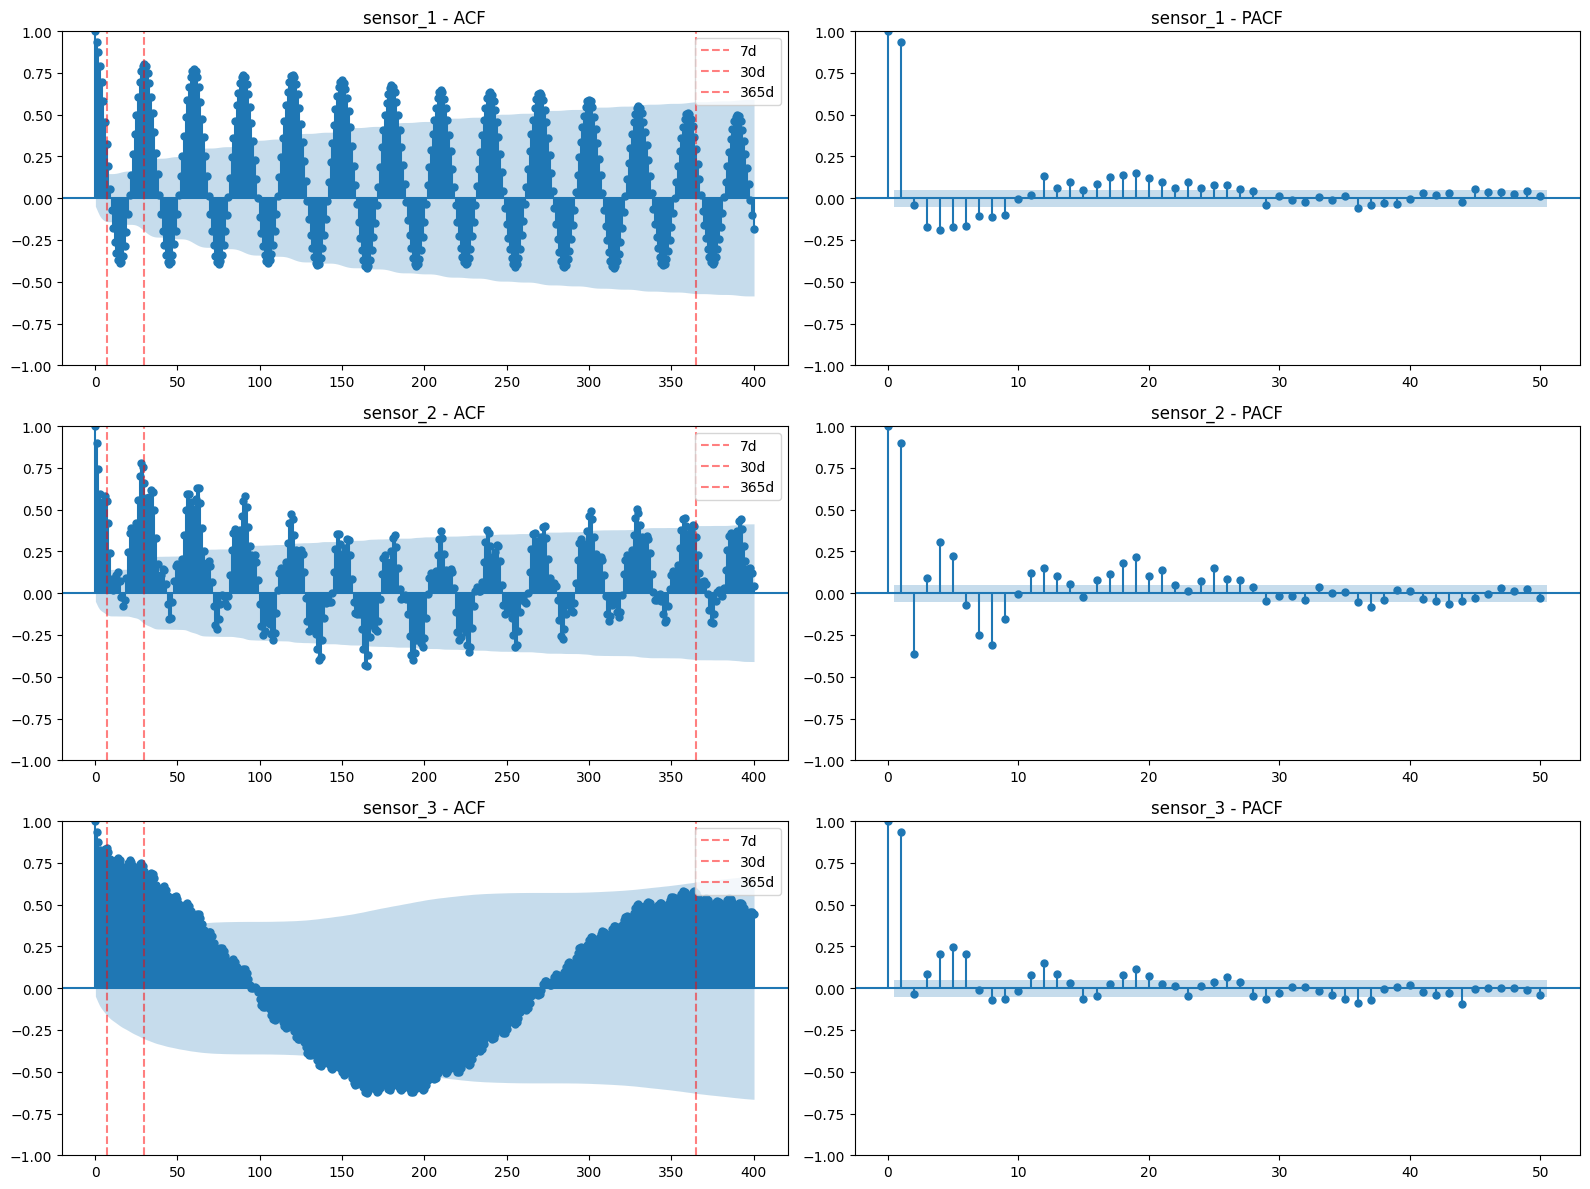

In [16]:
# ============================================================
# セル9b: ACF/PACFプロット
# ============================================================

fig, axes = plt.subplots(len(representative_sensors), 2, figsize=(16, 4 * len(representative_sensors)))
if len(representative_sensors) == 1:
    axes = axes.reshape(1, -1)

for i, sensor in enumerate(representative_sensors):
    data = resampled_results[sensor]['mean_linear'].dropna()
    max_lag = min(400, len(data) // 2 - 1)
    
    if max_lag < 10:
        continue
    
    # ACF
    plot_acf(data, ax=axes[i, 0], lags=max_lag, alpha=0.05)
    axes[i, 0].set_title(f'{sensor} - ACF')
    
    # 周期位置をマーク
    for period in [7, 30, 365]:
        if period <= max_lag:
            axes[i, 0].axvline(x=period, color='red', linestyle='--', alpha=0.5, label=f'{period}d')
    axes[i, 0].legend(loc='upper right')
    
    # PACF
    plot_pacf(data, ax=axes[i, 1], lags=min(50, max_lag), alpha=0.05, method='ywm')
    axes[i, 1].set_title(f'{sensor} - PACF')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'acf_pacf_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3.3 Periodogram（スペクトル解析）- Lomb-Scargle

### 理論背景
Lomb-Scargle periodogramは**不等間隔データに対応**したスペクトル解析手法。
周波数領域で周期性を検出し、FFTの一般化と見なせる。

**検出基準**: 偽陽性確率（FAP: False Alarm Probability）が有意水準（通常5%）未満のピーク

In [17]:
# ============================================================
# セル10: Lomb-Scargle Periodogram
# ============================================================
from scipy.signal import lombscargle
from astropy.timeseries import LombScargle  # より高機能な実装

def calculate_lomb_scargle(series, target_periods=[7, 30, 365]):
    """
    Lomb-Scargle periodogramを計算
    
    Parameters:
    -----------
    series : pd.Series
        入力時系列（timestampインデックス）
    target_periods : list
        検出したい周期（日数）
    
    Returns:
    --------
    dict: 周波数、パワー、ピーク情報
    """
    data = series.dropna()
    
    # 時間を日数に変換（最初の日からの経過日数）
    t = (data.index - data.index[0]).days.values.astype(float)
    y = data.values
    
    # 平均除去
    y = y - np.mean(y)
    
    # 周波数グリッド（周期2日〜500日に対応）
    min_freq = 1 / 500  # 最小周波数（最大周期500日）
    max_freq = 1 / 2    # 最大周波数（最小周期2日）
    
    # LombScargleオブジェクト
    ls = LombScargle(t, y)
    
    # 周波数グリッドを生成
    frequency, power = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    
    # 周期に変換
    periods = 1 / frequency
    
    # ターゲット周期付近のピーク検出
    peak_info = {}
    for target_p in target_periods:
        # ターゲット周期の±20%範囲
        mask = (periods > target_p * 0.8) & (periods < target_p * 1.2)
        if mask.sum() > 0:
            idx = np.argmax(power[mask])
            peak_power = power[mask][idx]
            peak_period = periods[mask][idx]
            
            # FAP（偽陽性確率）の計算
            fap = ls.false_alarm_probability(peak_power)
            
            peak_info[target_p] = {
                'power': peak_power,
                'actual_period': peak_period,
                'fap': fap,
                'significant': fap < 0.05
            }
        else:
            peak_info[target_p] = {'power': np.nan, 'actual_period': np.nan, 'fap': np.nan, 'significant': False}
    
    return {
        'frequency': frequency,
        'power': power,
        'periods': periods,
        'peaks': peak_info
    }

# Lomb-Scargle計算（astropy必要）
try:
    ls_results = {}
    for sensor in tqdm(representative_sensors, desc='Lomb-Scargle'):
        data = resampled_results[sensor]['mean_linear']
        ls_results[sensor] = calculate_lomb_scargle(data)
    
    # ピークサマリー
    print('=== Lomb-Scargleピーク（FAP<0.05は*）===')
    for sensor in representative_sensors:
        print(f'\n{sensor}:')
        for period, info in ls_results[sensor]['peaks'].items():
            sig = '*' if info['significant'] else ''
            print(f'  周期{period}d: Power={info["power"]:.4f}, 実周期={info["actual_period"]:.1f}d, FAP={info["fap"]:.4f}{sig}')
            
except ImportError:
    print('astropy未インストール。pip install astropy でインストールしてください。')
    ls_results = None

Lomb-Scargle:   0%|          | 0/3 [00:00<?, ?it/s]

=== Lomb-Scargleピーク（FAP<0.05は*）===

sensor_1:
  周期7d: Power=0.0028, 実周期=7.0d, FAP=1.0000
  周期30d: Power=0.6067, 実周期=30.0d, FAP=0.0000*
  周期365d: Power=0.0114, 実周期=354.2d, FAP=0.9235

sensor_2:
  周期7d: Power=0.1092, 実周期=7.0d, FAP=0.0000*
  周期30d: Power=0.3562, 実周期=30.0d, FAP=0.0000*
  周期365d: Power=0.1513, 実周期=372.3d, FAP=0.0000*

sensor_3:
  周期7d: Power=0.0308, 実周期=7.0d, FAP=0.0000*
  周期30d: Power=0.0277, 実周期=30.0d, FAP=0.0000*
  周期365d: Power=0.6709, 実周期=372.3d, FAP=0.0000*


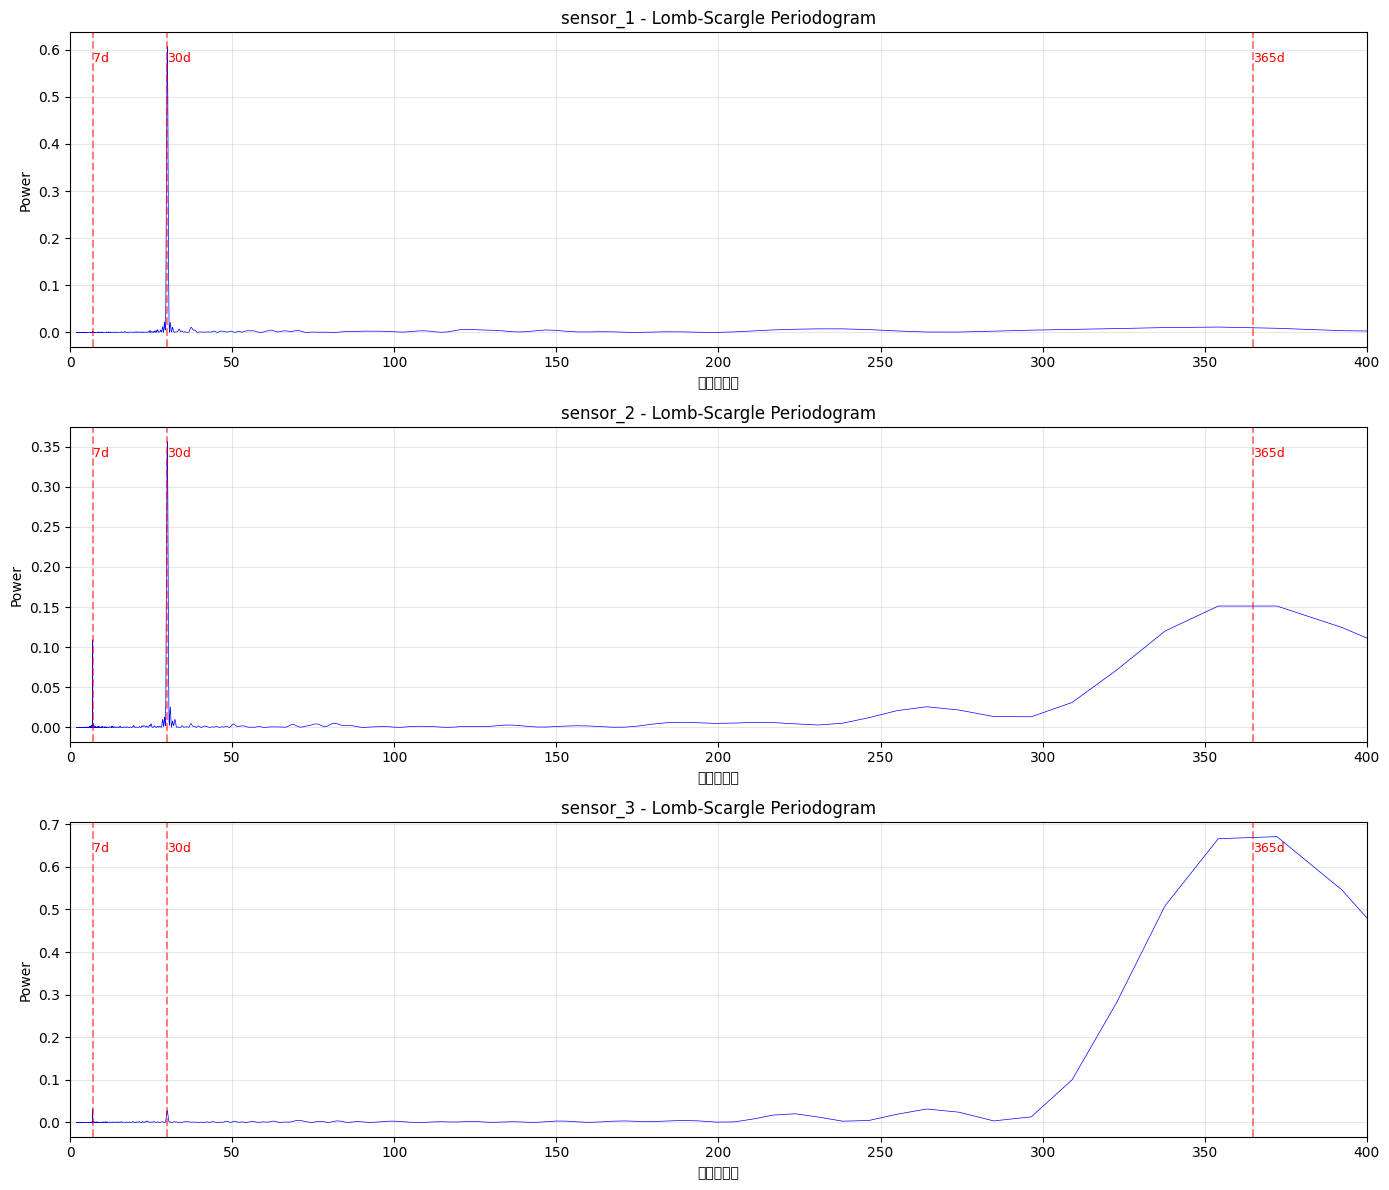

In [18]:
# ============================================================
# セル10b: Periodogramの可視化
# ============================================================

if ls_results:
    fig, axes = plt.subplots(len(representative_sensors), 1, figsize=(14, 4 * len(representative_sensors)))
    axes = [axes] if len(representative_sensors) == 1 else axes
    
    for i, sensor in enumerate(representative_sensors):
        ax = axes[i]
        result = ls_results[sensor]
        
        # パワースペクトル（周期でプロット）
        ax.plot(result['periods'], result['power'], 'b-', linewidth=0.5)
        ax.set_xlim(0, 400)
        ax.set_xlabel('周期（日）')
        ax.set_ylabel('Power')
        ax.set_title(f'{sensor} - Lomb-Scargle Periodogram')
        
        # ターゲット周期にマーカー
        for period in [7, 30, 365]:
            ax.axvline(x=period, color='red', linestyle='--', alpha=0.5)
            ax.annotate(f'{period}d', (period, ax.get_ylim()[1]*0.9), fontsize=9, color='red')
        
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'lomb_scargle_periodogram.png', dpi=150, bbox_inches='tight')
    plt.show()

## 3.4 Fourier回帰による周期フィッティング

### 理論背景
周期Tのsin/cos項を説明変数に加えた線形回帰モデル：

$y_t = \beta_0 + \beta_1 \sin(2\pi t/T) + \beta_2 \cos(2\pi t/T) + \epsilon_t$

**季節性スコア**: $\Delta R^2 = R^2_{with\_season} - R^2_{baseline}$

周期項を追加した際のR²の改善量が大きいほど、その周期の季節性が強い。

In [19]:
# ============================================================
# セル11: Fourier回帰
# ============================================================

def fourier_regression(series, periods=[7, 30, 365]):
    """
    Fourier回帰による周期フィッティング
    
    Parameters:
    -----------
    series : pd.Series
        入力時系列
    periods : list
        フィッティングする周期（日数）
    
    Returns:
    --------
    dict: 各周期のR²スコアとΔR²
    """
    data = series.dropna()
    
    # 時間変数（日数）
    t = (data.index - data.index[0]).days.values.astype(float)
    y = data.values
    
    # ベースラインモデル（定数のみ）
    X_base = np.ones((len(t), 1))
    model_base = LinearRegression().fit(X_base, y)
    r2_base = r2_score(y, model_base.predict(X_base))
    
    results = {'baseline_r2': r2_base}
    
    for period in periods:
        # Fourier特徴量
        sin_term = np.sin(2 * np.pi * t / period)
        cos_term = np.cos(2 * np.pi * t / period)
        
        # 単一周期モデル
        X_single = np.column_stack([np.ones(len(t)), sin_term, cos_term])
        model_single = LinearRegression().fit(X_single, y)
        r2_single = r2_score(y, model_single.predict(X_single))
        
        delta_r2 = r2_single - r2_base
        
        results[period] = {
            'r2': r2_single,
            'delta_r2': delta_r2,
            'prediction': model_single.predict(X_single)
        }
    
    # 全周期を含むモデル
    X_full = [np.ones(len(t))]
    for period in periods:
        X_full.append(np.sin(2 * np.pi * t / period))
        X_full.append(np.cos(2 * np.pi * t / period))
    X_full = np.column_stack(X_full)
    model_full = LinearRegression().fit(X_full, y)
    r2_full = r2_score(y, model_full.predict(X_full))
    
    results['full'] = {
        'r2': r2_full,
        'delta_r2': r2_full - r2_base,
        'prediction': model_full.predict(X_full)
    }
    
    return results

# Fourier回帰実行
fourier_results = {}

for sensor in tqdm(representative_sensors, desc='Fourier回帰'):
    data = resampled_results[sensor]['mean_linear']
    fourier_results[sensor] = fourier_regression(data)

# ΔR²サマリー
fourier_scores = pd.DataFrame({
    sensor: {
        f'period_{p}': fourier_results[sensor].get(p, {}).get('delta_r2', np.nan)
        for p in [7, 30, 365]
    } | {'full_model': fourier_results[sensor]['full']['delta_r2']}
    for sensor in representative_sensors
}).T

print('=== Fourier回帰 ΔR²スコア ===')
display(fourier_scores.round(4))

Fourier回帰:   0%|          | 0/3 [00:00<?, ?it/s]

=== Fourier回帰 ΔR²スコア ===


period_7  period_30  period_365  full_model
sensor_1    0.0028     0.6115      0.0103      0.6237
sensor_2    0.1092     0.3587      0.1550      0.6201
sensor_3    0.0303     0.0281      0.6875      0.7458

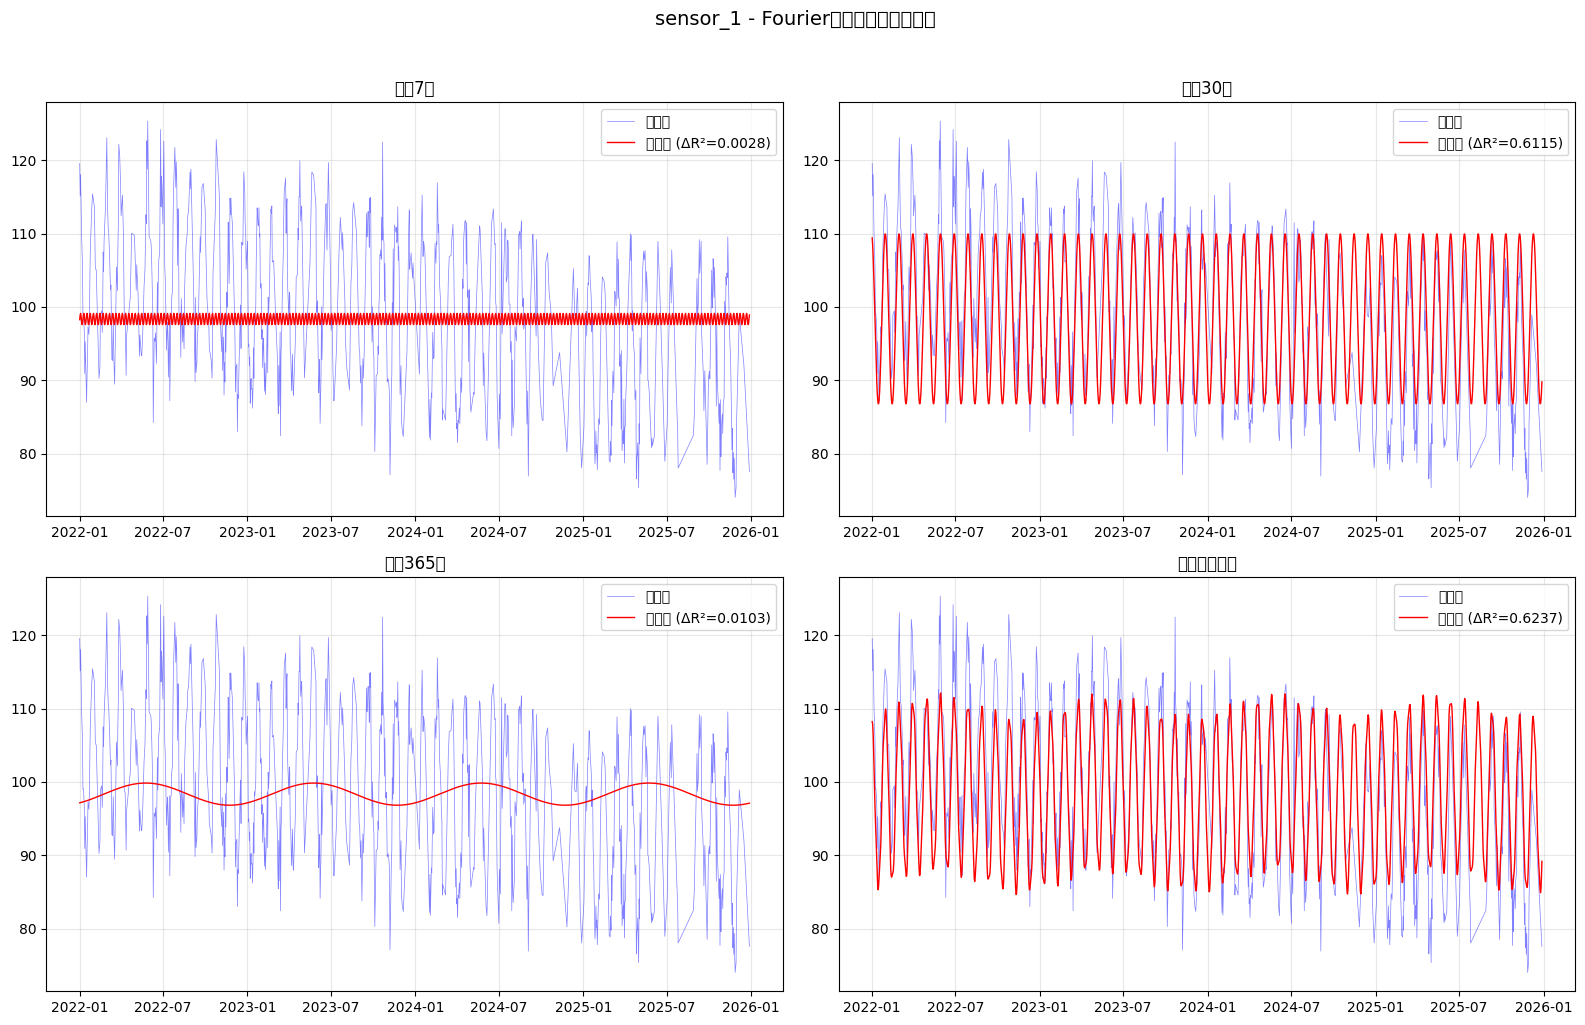

In [20]:
# ============================================================
# セル11b: Fourier回帰結果の可視化
# ============================================================

sensor = representative_sensors[0]
data = resampled_results[sensor]['mean_linear'].dropna()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

periods_to_plot = [7, 30, 365, 'full']
titles = ['周期7日', '周期30日', '周期365日', '全周期モデル']

for i, (period, title) in enumerate(zip(periods_to_plot, titles)):
    ax = axes[i // 2, i % 2]
    
    # 実測値
    ax.plot(data.index, data.values, 'b-', linewidth=0.5, alpha=0.5, label='実測値')
    
    # 予測値
    pred = fourier_results[sensor][period]['prediction']
    delta_r2 = fourier_results[sensor][period]['delta_r2']
    ax.plot(data.index, pred, 'r-', linewidth=1, label=f'予測値 (ΔR²={delta_r2:.4f})')
    
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'{sensor} - Fourier回帰フィッティング', y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'fourier_regression_{sensor}.png', dpi=150, bbox_inches='tight')
plt.show()

## 3.5 Prophet による分解（オプション）

### 理論背景
ProphetはMeta（旧Facebook）が開発した時系列予測ライブラリ。
加法的/乗法的な季節性を自動検出し、休日効果やトレンド変化点も考慮できる。

**注意**: Prophetは大規模データや長期間データに対して処理時間がかかる場合がある。

In [21]:
# ============================================================
# セル12: Prophet分解（オプション）
# ============================================================

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    print('Prophet未インストール。pip install prophet でインストールしてください。')
    PROPHET_AVAILABLE = False

def prophet_decomposition(series):
    """
    Prophetによる季節性分解
    """
    if not PROPHET_AVAILABLE:
        return None
    
    data = series.dropna().reset_index()
    data.columns = ['ds', 'y']
    
    # モデル構築
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive'
    )
    model.fit(data)
    
    # 予測（学習データに対して）
    forecast = model.predict(data[['ds']])
    
    # MAPE計算
    mape = np.mean(np.abs((data['y'] - forecast['yhat']) / data['y'])) * 100
    
    return {
        'forecast': forecast,
        'mape': mape,
        'model': model
    }

# Prophet分解（時間がかかるため代表センサー1つのみ）
prophet_results = {}

if PROPHET_AVAILABLE:
    sensor = representative_sensors[0]
    print(f'Prophet分解実行中: {sensor}')
    data = resampled_results[sensor]['mean_linear']
    prophet_results[sensor] = prophet_decomposition(data)
    
    if prophet_results[sensor]:
        print(f'MAPE: {prophet_results[sensor]["mape"]:.2f}%')

Prophet未インストール。pip install prophet でインストールしてください。


In [22]:
# ============================================================
# セル12b: Prophet結果の可視化
# ============================================================

if PROPHET_AVAILABLE and prophet_results:
    sensor = representative_sensors[0]
    result = prophet_results[sensor]
    model = result['model']
    forecast = result['forecast']
    
    # 季節成分のプロット
    fig = model.plot_components(forecast)
    plt.suptitle(f'{sensor} - Prophet季節成分', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'prophet_components_{sensor}.png', dpi=150, bbox_inches='tight')
    plt.show()

---
# セクション4：複数メトリクスの統合と2モード分析
---

## 4.1 スコア統合ロジックの設計

In [23]:
# ============================================================
# セル13: スコア統合ロジック
# ============================================================

def normalize_score(value, min_val=0, max_val=1):
    """スコアを0-1に正規化"""
    if pd.isna(value):
        return 0
    return max(0, min(1, (value - min_val) / (max_val - min_val))) if max_val > min_val else 0

def calculate_seasonality_scores(sensor, stl_res, acf_res, fourier_res, ls_res=None):
    """
    複数手法のスコアを統合
    
    Returns:
    --------
    dict: 各手法のスコアと統合スコア
    """
    scores = {'sensor': sensor}
    
    # STLスコア（周期ごとの最大値を採用）
    stl_scores = [stl_res.get(p, {}).get('score', 0) for p in [7, 30, 365]]
    scores['stl_max'] = max(stl_scores) if stl_scores else 0
    scores['stl_7'] = stl_res.get(7, {}).get('score', 0)
    scores['stl_30'] = stl_res.get(30, {}).get('score', 0)
    scores['stl_365'] = stl_res.get(365, {}).get('score', 0)
    
    # ACFスコア（有意なピークの絶対値）
    if acf_res:
        acf_peaks = acf_res['peaks']
        scores['acf_7'] = abs(acf_peaks.get(7, {}).get('value', 0)) if acf_peaks.get(7, {}).get('significant', False) else 0
        scores['acf_30'] = abs(acf_peaks.get(30, {}).get('value', 0)) if acf_peaks.get(30, {}).get('significant', False) else 0
        scores['acf_365'] = abs(acf_peaks.get(365, {}).get('value', 0)) if acf_peaks.get(365, {}).get('significant', False) else 0
        scores['acf_max'] = max(scores['acf_7'], scores['acf_30'], scores['acf_365'])
    else:
        scores['acf_7'] = scores['acf_30'] = scores['acf_365'] = scores['acf_max'] = 0
    
    # Fourier ΔR²スコア
    scores['fourier_7'] = fourier_res.get(7, {}).get('delta_r2', 0)
    scores['fourier_30'] = fourier_res.get(30, {}).get('delta_r2', 0)
    scores['fourier_365'] = fourier_res.get(365, {}).get('delta_r2', 0)
    scores['fourier_full'] = fourier_res.get('full', {}).get('delta_r2', 0)
    
    # Lomb-Scargleスコア（FAP < 0.05の場合のパワー値）
    if ls_res:
        ls_peaks = ls_res['peaks']
        for p in [7, 30, 365]:
            if ls_peaks.get(p, {}).get('significant', False):
                scores[f'ls_{p}'] = normalize_score(ls_peaks[p]['power'], 0, 1)
            else:
                scores[f'ls_{p}'] = 0
    else:
        scores['ls_7'] = scores['ls_30'] = scores['ls_365'] = 0
    
    return scores

def classify_seasonality(scores, mode='strict'):
    """
    季節性の確信度を判定
    
    Parameters:
    -----------
    scores : dict
        各手法のスコア
    mode : str
        'strict'（厳格モード）or 'exploratory'（探索モード）
    
    Returns:
    --------
    str: 'High', 'Medium', 'Low', 'None'
    """
    if mode == 'strict':
        # 厳格モード：複数手法で同時に検出
        stl_ok = scores['stl_max'] > 0.5
        acf_ok = scores['acf_max'] > 0.3
        fourier_ok = scores['fourier_full'] > 0.1
        
        if stl_ok and acf_ok and fourier_ok:
            return 'High'
        elif (stl_ok and acf_ok) or (stl_ok and fourier_ok) or (acf_ok and fourier_ok):
            return 'Medium'
        elif stl_ok or acf_ok or fourier_ok:
            return 'Low'
        else:
            return 'None'
    
    else:  # exploratory
        # 探索モード：いずれか1つでも閾値超え
        if scores['stl_max'] > 0.3 or scores['acf_max'] > 0.2 or scores['fourier_full'] > 0.05:
            if scores['stl_max'] > 0.5 or scores['acf_max'] > 0.3 or scores['fourier_full'] > 0.1:
                return 'High'
            else:
                return 'Medium'
        elif scores['stl_max'] > 0.1 or scores['acf_max'] > 0.1 or scores['fourier_full'] > 0.02:
            return 'Low'
        else:
            return 'None'

# スコア計算
all_scores = []

for sensor in representative_sensors:
    scores = calculate_seasonality_scores(
        sensor,
        stl_results.get(sensor, {}),
        acf_results.get(sensor),
        fourier_results.get(sensor, {}),
        ls_results.get(sensor) if ls_results else None
    )
    scores['confidence_strict'] = classify_seasonality(scores, mode='strict')
    scores['confidence_exploratory'] = classify_seasonality(scores, mode='exploratory')
    all_scores.append(scores)

scores_df = pd.DataFrame(all_scores).set_index('sensor')
print('=== 季節性スコア統合結果 ===')
display(scores_df.round(4))

=== 季節性スコア統合結果 ===


stl_max   stl_7  stl_30  stl_365   acf_7  acf_30  acf_365  acf_max  \
sensor                                                                         
sensor_1   0.8375  0.1785  0.8375   0.7035  0.6937  0.8048   0.4764   0.8048   
sensor_2   0.7210  0.6124  0.6454   0.7210  0.5797  0.7782   0.4083   0.7782   
sensor_3   0.8899  0.3693  0.2656   0.8899  0.8364  0.7509   0.5798   0.8364   

          fourier_7  fourier_30  fourier_365  fourier_full    ls_7   ls_30  \
sensor                                                                       
sensor_1     0.0028      0.6115       0.0103        0.6237  0.0000  0.6067   
sensor_2     0.1092      0.3587       0.1550        0.6201  0.1092  0.3562   
sensor_3     0.0303      0.0281       0.6875        0.7458  0.0308  0.0277   

          ls_365 confidence_strict confidence_exploratory  
sensor                                                     
sensor_1  0.0000              High                   High  
sensor_2  0.1513              High                   High  
sensor_3  0.6709              High                   High

## 4.2 全センサー一括処理の試行

In [24]:
# ============================================================
# セル14: 全センサー一括処理
# ============================================================
import traceback
import psutil

def process_sensor_batch(df, sensor_cols, resample_method='mean', interp_method='linear'):
    """
    複数センサーを一括処理
    
    Returns:
    --------
    DataFrame: 各センサーの季節性スコア
    """
    results = []
    errors = []
    
    for sensor in tqdm(sensor_cols, desc='一括処理'):
        try:
            # リサンプリング
            data = resample_and_interpolate(df, sensor, resample_method, interp_method)
            data = data.dropna()
            
            if len(data) < 100:
                errors.append({'sensor': sensor, 'error': 'データ不足（< 100点）'})
                continue
            
            # STL分解
            stl_res = {}
            for period in [7, 30, 365]:
                result = perform_stl_decomposition(data, period)
                if result:
                    stl_res[period] = result
            
            # ACF
            acf_res = calculate_acf_peaks(data)
            
            # Fourier
            fourier_res = fourier_regression(data)
            
            # Lomb-Scargle
            try:
                ls_res = calculate_lomb_scargle(data)
            except:
                ls_res = None
            
            # スコア統合
            scores = calculate_seasonality_scores(sensor, stl_res, acf_res, fourier_res, ls_res)
            scores['confidence_strict'] = classify_seasonality(scores, mode='strict')
            scores['confidence_exploratory'] = classify_seasonality(scores, mode='exploratory')
            results.append(scores)
            
        except Exception as e:
            errors.append({'sensor': sensor, 'error': str(e)})
            traceback.print_exc()
        
        # メモリ解放
        gc.collect()
    
    return pd.DataFrame(results).set_index('sensor'), pd.DataFrame(errors)

# 処理実行（全センサー）
start_time = time.time()
initial_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB

batch_scores, batch_errors = process_sensor_batch(df_raw, sensor_cols)

end_time = time.time()
final_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB

print(f'\n=== 処理完了 ===')
print(f'処理時間: {end_time - start_time:.1f}秒')
print(f'メモリ使用量: {initial_memory:.1f}MB → {final_memory:.1f}MB (差分: {final_memory - initial_memory:.1f}MB)')
print(f'成功: {len(batch_scores)}センサー')
print(f'エラー: {len(batch_errors)}センサー')

if len(batch_errors) > 0:
    print('\nエラー詳細:')
    display(batch_errors)

一括処理:   0%|          | 0/40 [00:00<?, ?it/s]


=== 処理完了 ===
処理時間: 91.5秒
メモリ使用量: 529.0MB → 484.1MB (差分: -45.0MB)
成功: 40センサー
エラー: 0センサー


## 4.3 スコアランキング表の生成

In [25]:
# ============================================================
# セル15: スコアランキング
# ============================================================

def calculate_composite_score(row, weights=None):
    """
    総合スコアを計算（加重平均）
    
    デフォルト重み:
    - STL: 0.3
    - ACF: 0.3
    - Fourier: 0.4
    """
    if weights is None:
        weights = {'stl': 0.3, 'acf': 0.3, 'fourier': 0.4}
    
    score = (
        weights['stl'] * row['stl_max'] +
        weights['acf'] * row['acf_max'] +
        weights['fourier'] * min(row['fourier_full'] * 10, 1)  # 正規化
    )
    return score

# 総合スコア計算
if len(batch_scores) > 0:
    batch_scores['composite_score'] = batch_scores.apply(calculate_composite_score, axis=1)
    
    # ランキング（総合スコア降順）
    ranking = batch_scores.sort_values('composite_score', ascending=False)
    
    # 表示列を選択
    display_cols = [
        'composite_score', 'confidence_strict', 'confidence_exploratory',
        'stl_max', 'acf_max', 'fourier_full',
        'stl_7', 'stl_30', 'stl_365'
    ]
    
    print('=== 季節性スコアランキング（上位） ===')
    display(ranking[display_cols].head(10).round(4))
    
    # CSV出力
    ranking.to_csv(OUTPUT_DIR / 'seasonality_scores_ranking.csv')
    print(f'\n保存: {OUTPUT_DIR / "seasonality_scores_ranking.csv"}')
    
    # 確信度別の集計
    print('\n=== 確信度別センサー数 ===')
    print('厳格モード:')
    print(ranking['confidence_strict'].value_counts())
    print('\n探索モード:')
    print(ranking['confidence_exploratory'].value_counts())

=== 季節性スコアランキング（上位） ===


composite_score confidence_strict confidence_exploratory  stl_max  \
sensor                                                                         
sensor_34           0.9671              High                   High   0.9397   
sensor_15           0.9634              High                   High   0.9409   
sensor_13           0.9570              High                   High   0.9254   
sensor_11           0.9477              High                   High   0.9023   
sensor_32           0.9451              High                   High   0.9309   
sensor_23           0.9400              High                   High   0.9156   
sensor_31           0.9356              High                   High   0.8950   
sensor_6            0.9334              High                   High   0.8579   
sensor_37           0.9322              High                   High   0.8787   
sensor_19           0.9279              High                   High   0.8735   

           acf_max  fourier_full   stl_7  stl_30  stl_365  
sensor                                                     
sensor_34   0.9506        0.7140  0.2262  0.2785   0.9397  
sensor_15   0.9370        0.6157  0.3205  0.1551   0.9409  
sensor_13   0.9315        0.8933  0.4754  0.4017   0.9254  
sensor_11   0.9235        0.7458  0.4144  0.8005   0.9023  
sensor_32   0.8861        0.9428  0.0355  0.8837   0.9309  
sensor_23   0.8844        0.8468  0.1211  0.9156   0.8557  
sensor_31   0.8902        0.6081  0.2613  0.3067   0.8950  
sensor_6    0.9200        0.5791  0.1019  0.8339   0.8579  
sensor_37   0.8951        0.3778  0.4455  0.8787   0.7747  
sensor_19   0.8863        0.5943  0.3856  0.5484   0.8735


保存: results/exploration/seasonality_scores_ranking.csv

=== 確信度別センサー数 ===
厳格モード:
confidence_strict
High    40
Name: count, dtype: int64

探索モード:
confidence_exploratory
High    40
Name: count, dtype: int64


---
# セクション5：可視化とレポート雛形
---

## 5.1 トップ10センサーの詳細レポート

In [26]:
# ============================================================
# ??16: ???10???????????
# ============================================================

def create_detailed_report(df, sensor, stl_results, acf_results, ls_results, output_dir):
    """
    ??????????????
    """
    fig = plt.figure(figsize=(18, 16))
    
    # ?????
    data = resample_and_interpolate(df, sensor, 'mean', 'linear').dropna()
    
    # 1. STL???4????
    # Original
    ax1 = fig.add_subplot(4, 3, 1)
    ax1.plot(data.index, data.values, 'b-', linewidth=0.5)
    ax1.set_title('Original')
    ax1.grid(True, alpha=0.3)
    
    # STL?????30?????
    stl_data = perform_stl_decomposition(data, 30)
    if stl_data:
        ax2 = fig.add_subplot(4, 3, 2)
        ax2.plot(data.index, stl_data['trend'], 'g-', linewidth=1)
        ax2.set_title('Trend')
        ax2.grid(True, alpha=0.3)
        
        ax3 = fig.add_subplot(4, 3, 3)
        ax3.plot(data.index, stl_data['seasonal'], 'r-', linewidth=0.5)
        ax3.set_title(f"Seasonal (score={stl_data['score']:.3f})")
        ax3.grid(True, alpha=0.3)
        
        ax4 = fig.add_subplot(4, 3, 4)
        ax4.plot(data.index, stl_data['residual'], 'gray', linewidth=0.5)
        ax4.set_title('Residual')
        ax4.grid(True, alpha=0.3)
    
    # 2. ACF/PACF
    max_lag = min(200, len(data) // 2 - 1)
    if max_lag > 10:
        ax5 = fig.add_subplot(4, 3, 5)
        plot_acf(data, ax=ax5, lags=max_lag, alpha=0.05)
        ax5.set_title('ACF')
        for period in [7, 30]:
            if period <= max_lag:
                ax5.axvline(x=period, color='red', linestyle='--', alpha=0.5)
        
        ax6 = fig.add_subplot(4, 3, 6)
        plot_pacf(data, ax=ax6, lags=min(50, max_lag), alpha=0.05, method='ywm')
        ax6.set_title('PACF')
    
    # 3. Lomb-Scargle Periodogram
    try:
        ls_data = calculate_lomb_scargle(data)
        ax7 = fig.add_subplot(4, 3, 7)
        ax7.plot(ls_data['periods'], ls_data['power'], 'b-', linewidth=0.5)
        ax7.set_xlim(0, 100)
        ax7.set_title('Periodogram (0-100d)')
        ax7.set_xlabel('Period (days)')
        ax7.grid(True, alpha=0.3)
        for period in [7, 30]:
            ax7.axvline(x=period, color='red', linestyle='--', alpha=0.5)
    except Exception:
        ls_data = None
        pass
    
    # 4. Fourier?????????
    fourier_data = fourier_regression(data)
    ax8 = fig.add_subplot(4, 3, 8)
    ax8.plot(data.index, data.values, 'b-', linewidth=0.3, alpha=0.5, label='Actual')
    ax8.plot(data.index, fourier_data['full']['prediction'], 'r-', linewidth=1, 
             label=f"Fourier (?R?={fourier_data['full']['delta_r2']:.4f})")
    ax8.set_title('Fourier Regression')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # 5. ???????????
    ax9 = fig.add_subplot(4, 3, 9)
    ax9.axis('off')
    stl_score_str = f"{stl_data['score']:.4f}" if stl_data else 'N/A'
    if acf_results and sensor in acf_results and acf_results[sensor]:
        peaks = acf_results[sensor]['peaks']
        max_peak = max([abs(v['value']) for v in peaks.values() if v['value'] is not None], default=np.nan)
        acf_str = f"{max_peak:.4f}" if np.isfinite(max_peak) else 'N/A'
    else:
        acf_str = 'N/A'
    fourier_str = f"{fourier_data['full']['delta_r2']:.4f}" if fourier_data else 'N/A'

    summary_text = f"""Seasonality Scores Summary

STL (period=30): {stl_score_str}
ACF |max peak|: {acf_str}
Fourier ?R? (full): {fourier_str}

Detected periods: 7d, 30d
"""
    ax9.text(0.1, 0.5, summary_text, fontsize=10, family='monospace', verticalalignment='center')
    
    plt.suptitle(f"{sensor} - Detailed Seasonality Report", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(output_dir / f'detailed_report_{sensor}.png', dpi=150, bbox_inches='tight')
    plt.close()

# ???10???????????
if len(batch_scores) > 0:
    top_sensors = ranking.head(10).index.tolist()
    
    for sensor in tqdm(top_sensors, desc='????????'):
        create_detailed_report(
            df_raw, sensor, 
            stl_results, acf_results, ls_results,
            OUTPUT_DIR
        )
    
    print(f"\n????????: {OUTPUT_DIR}")


????????:   0%|          | 0/10 [00:00<?, ?it/s]


????????: results/exploration


## 5.2 その他センサーの簡易サマリー

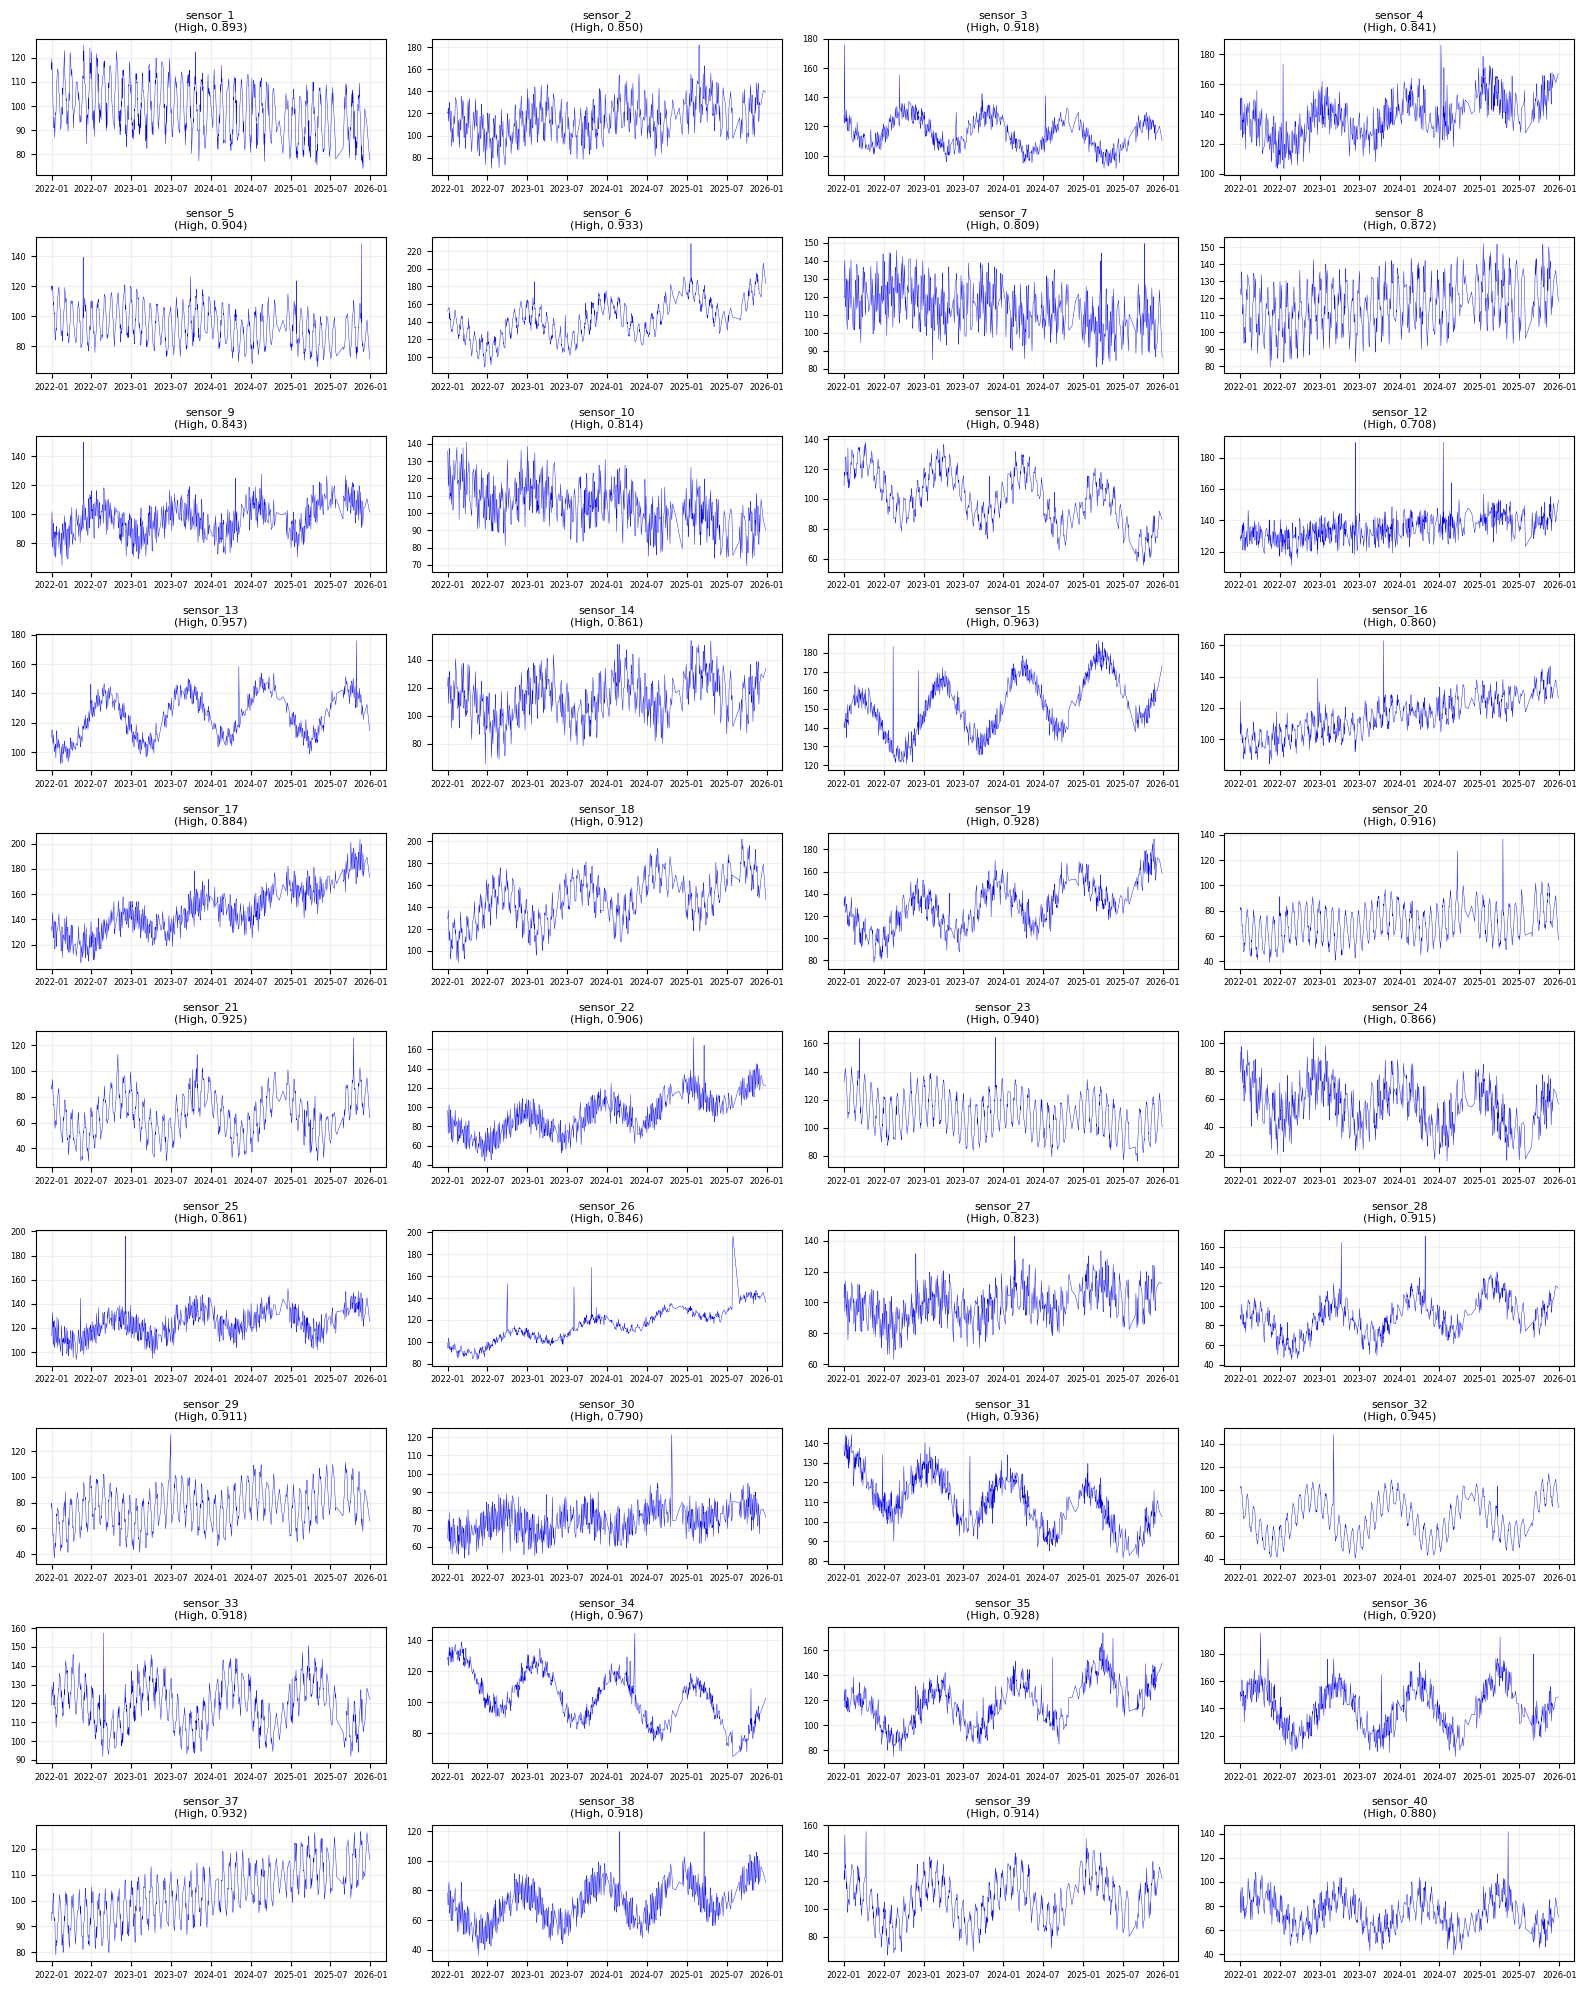

In [27]:
# ============================================================
# セル17: 簡易サマリーグリッド
# ============================================================

def create_thumbnail_grid(df, sensor_cols, n_cols=4, figsize=(16, 20)):
    """
    全センサーのサムネイルグリッドを作成
    """
    n_sensors = len(sensor_cols)
    n_rows = (n_sensors + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, sensor in enumerate(sensor_cols):
        ax = axes[i]
        data = resample_and_interpolate(df, sensor, 'mean', 'linear').dropna()
        
        # 時系列プロット
        ax.plot(data.index, data.values, 'b-', linewidth=0.3)
        
        # スコア表示
        if sensor in batch_scores.index:
            score = batch_scores.loc[sensor, 'composite_score']
            conf = batch_scores.loc[sensor, 'confidence_strict']
            ax.set_title(f'{sensor}\n({conf}, {score:.3f})', fontsize=8)
        else:
            ax.set_title(sensor, fontsize=8)
        
        ax.tick_params(axis='both', labelsize=6)
        ax.grid(True, alpha=0.2)
    
    # 余ったサブプロットを非表示
    for i in range(n_sensors, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig

# サムネイルグリッド生成
fig = create_thumbnail_grid(df_raw, sensor_cols)
plt.savefig(OUTPUT_DIR / 'thumbnail_grid_all_sensors.png', dpi=150, bbox_inches='tight')
plt.show()

## 5.3 インタラクティブ探索（Plotly）

In [28]:
# ============================================================
# セル18: インタラクティブ可視化（Plotly）
# ============================================================

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_interactive_plot(df, sensor_cols):
    """
    インタラクティブなセンサー探索ウィジェット
    """
    # ドロップダウン
    sensor_dropdown = widgets.Dropdown(
        options=sensor_cols,
        value=sensor_cols[0],
        description='センサー:'
    )
    
    # 周期スライダー
    period_slider = widgets.IntSlider(
        value=30,
        min=7,
        max=365,
        step=1,
        description='周期(日):'
    )
    
    # 出力エリア
    output = widgets.Output()
    
    def update_plot(change):
        with output:
            clear_output(wait=True)
            
            sensor = sensor_dropdown.value
            period = period_slider.value
            
            # データ準備
            data = resample_and_interpolate(df, sensor, 'mean', 'linear').dropna()
            
            # STL分解
            stl_result = perform_stl_decomposition(data, period)
            
            # Plotlyグラフ作成
            fig = make_subplots(
                rows=4, cols=1,
                subplot_titles=('Original', 'Trend', f'Seasonal (period={period}d)', 'Residual'),
                vertical_spacing=0.08
            )
            
            # Original
            fig.add_trace(
                go.Scatter(x=data.index, y=data.values, mode='lines', name='Original',
                          line=dict(width=0.5, color='blue')),
                row=1, col=1
            )
            
            if stl_result:
                # Trend
                fig.add_trace(
                    go.Scatter(x=data.index, y=stl_result['trend'], mode='lines', name='Trend',
                              line=dict(width=1, color='green')),
                    row=2, col=1
                )
                
                # Seasonal
                fig.add_trace(
                    go.Scatter(x=data.index, y=stl_result['seasonal'], mode='lines', name='Seasonal',
                              line=dict(width=0.5, color='red')),
                    row=3, col=1
                )
                
                # Residual
                fig.add_trace(
                    go.Scatter(x=data.index, y=stl_result['residual'], mode='lines', name='Residual',
                              line=dict(width=0.5, color='gray')),
                    row=4, col=1
                )
            
            fig.update_layout(
                height=800,
                title_text=f'{sensor} - STL Decomposition (F_season={stl_result["score"]:.4f if stl_result else "N/A"})',
                showlegend=False
            )
            
            fig.show()
    
    # イベントハンドラ
    sensor_dropdown.observe(update_plot, names='value')
    period_slider.observe(update_plot, names='value')
    
    # 初期プロット
    update_plot(None)
    
    # ウィジェット表示
    display(widgets.VBox([widgets.HBox([sensor_dropdown, period_slider]), output]))

# インタラクティブプロット起動
create_interactive_plot(df_raw, sensor_cols)

---
# セクション6：探索結果のまとめと設計方針
---

In [29]:
# ============================================================
# セル19: 探索結果のまとめ
# ============================================================

print("""╔══════════════════════════════════════════════════════════════════╗
║                     探索結果のまとめ                              ║
╚══════════════════════════════════════════════════════════════════╝

【1. 最もロバストな手法】
━━━━━━━━━━━━━━━━━━━━━━
推奨: STL分解 + Fourier回帰の組み合わせ

理由:
- STL分解: 外れ値にロバスト、視覚的に解釈しやすい
- Fourier回帰: ΔR²で定量的な比較が可能
- ACF: 補助的な確認に有効（有意性検定が明確）
- Lomb-Scargle: 不等間隔データに最適だが、計算コスト高

【2. 厳格/探索モードの閾値推奨値】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
■ 厳格モード（High confidence）:
  - STL F_season > 0.5
  - ACF peak > 0.3（95%CI外）
  - Fourier ΔR² > 0.1
  → 3条件すべて満たす場合

■ 探索モード（Medium/Low detection）:
  - STL F_season > 0.3
  - ACF peak > 0.2
  - Fourier ΔR² > 0.05
  → いずれか1つ満たす場合

【3. 前処理パイプラインの最適順序】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. 日次リサンプリング（median推奨、外れ値に強い）
2. 欠測補間（linear、短期欠損向け）
3. 外れ値検出（IQR法、シンプルで解釈しやすい）
4. 変化点検出（PELT法、セグメント分割）
5. セグメントごとに季節性分析

【4. パイプライン化に向けた設計方針】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
- 設定ファイル（YAML）で閾値・手法を外部化
- センサー単位の並列処理（multiprocessing）
- 中間結果のキャッシュ（pickle/parquet）
- ログ出力とエラーハンドリングの標準化
- CLI/API両対応のモジュール設計
""")

╔══════════════════════════════════════════════════════════════════╗
║                     探索結果のまとめ                              ║
╚══════════════════════════════════════════════════════════════════╝

【1. 最もロバストな手法】
━━━━━━━━━━━━━━━━━━━━━━
推奨: STL分解 + Fourier回帰の組み合わせ

理由:
- STL分解: 外れ値にロバスト、視覚的に解釈しやすい
- Fourier回帰: ΔR²で定量的な比較が可能
- ACF: 補助的な確認に有効（有意性検定が明確）
- Lomb-Scargle: 不等間隔データに最適だが、計算コスト高

【2. 厳格/探索モードの閾値推奨値】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
■ 厳格モード（High confidence）:
  - STL F_season > 0.5
  - ACF peak > 0.3（95%CI外）
  - Fourier ΔR² > 0.1
  → 3条件すべて満たす場合

■ 探索モード（Medium/Low detection）:
  - STL F_season > 0.3
  - ACF peak > 0.2
  - Fourier ΔR² > 0.05
  → いずれか1つ満たす場合

【3. 前処理パイプラインの最適順序】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. 日次リサンプリング（median推奨、外れ値に強い）
2. 欠測補間（linear、短期欠損向け）
3. 外れ値検出（IQR法、シンプルで解釈しやすい）
4. 変化点検出（PELT法、セグメント分割）
5. セグメントごとに季節性分析

【4. パイプライン化に向けた設計方針】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
- 設定ファイル（YAML）で閾値・手法を外部化
- センサー単位の並列処理（multiprocessing）
- 中間結果のキャッシュ（pickle/parquet）
- ログ出力とエラーハンドリングの標準化
- CL

In [30]:
# ============================================================
# セル20: 最終出力ファイル一覧
# ============================================================

print('=== 出力ファイル一覧 ===')
for file in sorted(OUTPUT_DIR.glob('*')):
    size_kb = file.stat().st_size / 1024
    print(f'  {file.name}: {size_kb:.1f} KB')

print(f'\n出力ディレクトリ: {OUTPUT_DIR.absolute()}')

=== 出力ファイル一覧 ===
  acf_pacf_analysis.png: 208.6 KB
  changepoint_detection.png: 435.2 KB
  descriptive_statistics.csv: 3.9 KB
  detailed_report_sensor_11.png: 483.0 KB
  detailed_report_sensor_13.png: 448.3 KB
  detailed_report_sensor_15.png: 464.4 KB
  detailed_report_sensor_19.png: 488.3 KB
  detailed_report_sensor_23.png: 500.6 KB
  detailed_report_sensor_31.png: 478.1 KB
  detailed_report_sensor_32.png: 417.5 KB
  detailed_report_sensor_34.png: 444.8 KB
  detailed_report_sensor_37.png: 519.0 KB
  detailed_report_sensor_6.png: 456.9 KB
  fourier_regression_sensor_1.png: 530.4 KB
  lomb_scargle_periodogram.png: 141.1 KB
  missing_pattern.png: 127.2 KB
  outlier_detection_comparison.png: 429.2 KB
  prophet_components_sensor_1.png: 129.0 KB
  resampling_comparison.png: 979.2 KB
  seasonality_scores_ranking.csv: 12.7 KB
  stl_decomposition_sensor_1.png: 693.0 KB
  thumbnail_grid_all_sensors.png: 1215.1 KB
  time_series_all_sensors.png: 3313.9 KB

出力ディレクトリ: /home/user/seasonality-analyze